In [1]:
import pandas as pd, numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.stats import pearsonr,chi2_contingency, kstest, shapiro, kruskal, spearmanr
import plotly.express as px
import seaborn as sns
from datetime import datetime
from imblearn.pipeline import Pipeline
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
from optbinning import OptimalBinning
from imblearn.under_sampling import TomekLinks,OneSidedSelection, RandomUnderSampler, CondensedNearestNeighbour, NeighbourhoodCleaningRule
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SMOTENC
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import SVC
import shap
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score,
                            precision_recall_curve, auc)
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings, xgboost as xgb
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import matplotlib.ticker as ticker
import scikitplot as skplt
warnings.simplefilter(action='ignore')# , category=FutureWarning


import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import to_categorical 

(CVXPY) Sep 14 11:29:43 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 14 11:29:43 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pd.set_option('display.max_columns',None)

warnings.simplefilter("ignore")

## Construction de la Base d'apprentissage

In [3]:
## Chargement fichier de Base

df_region =pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\DATA - DOSSIER PERSO EQUIPE\DATA - Dossier Patrick\Projet_DV\Dictionnaire_SD_Region_equipe_Data.csv",delimiter=';',engine='python',encoding='mbcs')

df_region.head()

CODSEC CODSEC_text     REGION
0     54         054  Grand Est
1     55         055  Grand Est
2     57         057  Grand Est
3     67         067  Grand Est
4     68         068  Grand Est

In [4]:
## Chargement fichier de devis 2021

df_base_devis = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2023\df_base_devis_2023")

df_base_devis.head()

NOIDE  TOP_ASSUR_VIE  DATNAI  Age  TOP_DECES  TOP_CAM  \
0  0103544722              1    1992   30          1        0   
1  0105893027              1    1999   23          1        0   
2  0106217145              1    1981   41          0        0   
3  0107977127              1    1959   63          0        0   
4  0105891091              1    1997   25          0        0   

   TOP_TOUT_HABITAT  TOP_HABITAT_MGEN  TOP_OBS  TOP_PIM  TOP_RETRAITE  \
0                 0                 0        0        0             0   
1                 0                 0        0        0             0   
2                 0                 0        0        0             0   
3                 0                 0        0        0             0   
4                 0                 0        0        0             0   

   AVEC_MAIL  AVEC_TEL_FIX  AVEC_TEL_PORT  AVEC_ADRESSE NAT_ACTIVITE  \
0        1.0           1.0            1.0           1.0        Actif   
1        1.0           0.0            1.0           1.0          NaN   
2        1.0           0.0            1.0           1.0        Actif   
3        1.0           1.0            1.0           1.0        Actif   
4        1.0           0.0            1.0           1.0          NaN   

   PROMOANACOUR  PROMOANAMAIL  PROMOANASMS  PROMOANATEL  PROMOHANACOUR  \
0             1             0            0            1              1   
1             1             1            1            1              1   
2             1             1            1            1              1   
3             1             1            1            1              1   
4             1             1            1            1              1   

   PROMOHANAMAIL  PROMOHANASMS  PROMOHANATEL  PIM_Cour  PIM_MAIL  PIM_SMS  \
0              0             0             1       1.0       0.0      0.0   
1              1             1             1       1.0       1.0      1.0   
2              0             0             1       1.0       0.0      0.0   
3              0             0             1       1.0       0.0      0.0   
4              0             0             1       1.0       0.0      0.0   

   PIM_TEL  RETRAITE_Cour  RETRAITE_MAIL  RETRAITE_SMS  RETRAITE_TEL  \
0      1.0            1.0            0.0           0.0           1.0   
1      1.0            1.0            1.0           1.0           1.0   
2      1.0            1.0            1.0           1.0           1.0   
3      1.0            1.0            1.0           1.0           1.0   
4      1.0            1.0            1.0           1.0           1.0   

   ASSUR_VIE_Cour  ASSUR_VIE_MAIL  ASSUR_VIE_SMS  ASSUR_VIE_TEL  DECES_Cour  \
0             0.0             0.0            0.0            0.0         0.0   
1             0.0             0.0            0.0            0.0         0.0   
2             0.0             0.0            0.0            0.0         1.0   
3             0.0             0.0            0.0            0.0         1.0   
4             0.0             0.0            0.0            0.0         1.0   

   DECES_MAIL  DECES_SMS  DECES_TEL  OBS_Cour  OBS_MAIL  OBS_SMS  OBS_TEL  \
0         0.0        0.0        0.0       1.0       0.0      0.0      1.0   
1         0.0        0.0        0.0       1.0       1.0      1.0      1.0   
2         1.0        1.0        1.0       1.0       1.0      1.0      1.0   
3         1.0        1.0        1.0       1.0       1.0      1.0      1.0   
4         1.0        1.0        1.0       1.0       1.0      1.0      1.0   

   CAM_Cour  CAM_MAIL  CAM_SMS  CAM_TEL  TOUT_HABITAT_Cour  TOUT_HABITAT_MAIL  \
0       1.0       0.0      0.0      1.0                1.0                0.0   
1       1.0       1.0      1.0      1.0                1.0                1.0   
2       1.0       1.0      1.0      1.0                1.0                1.0   
3       1.0       1.0      1.0      1.0                1.0                1.0   
4       1.0       1.0      1.0      1.0                1.0   

In [5]:
## Canal via lequel l'adhérent peut être contacté

df_base_devis["Contact_Tel"] = df_base_devis[["PROMOANATEL","AVEC_TEL_FIX","AVEC_TEL_PORT"]].apply(lambda x:
                                    1 if (x.AVEC_TEL_FIX==1 or x.AVEC_TEL_PORT==1) and x.PROMOANATEL==1 else 0,axis=1)

df_base_devis["Contact_Mail"] = df_base_devis[["PROMOANAMAIL","AVEC_MAIL"]].apply(lambda x:
                                    1 if x.AVEC_MAIL==1 and x.PROMOANAMAIL==1 else 0,axis=1)


df_base_devis["Contact_SMS"] = df_base_devis[["PROMOANASMS","AVEC_TEL_PORT"]].apply(lambda x:
                                    1 if x.AVEC_TEL_PORT==1 and x.PROMOANASMS==1 else 0,axis=1)

df_base_devis["Contact_Cour"] = df_base_devis[["PROMOANACOUR","AVEC_ADRESSE"]].apply(lambda x:
                                    1 if x.AVEC_ADRESSE==1 and x.PROMOANACOUR==1 else 0,axis=1)

df_base_devis["Nbre_canaux_dispo"] = df_base_devis[["Contact_Tel","Contact_Mail","Contact_SMS","Contact_Cour"]].sum(axis=1)

In [6]:
## Selection des colonnes

df_base_devis = df_base_devis[['NOIDE', 'TOP_ASSUR_VIE', 'DATNAI', 'Age', 'TOP_DECES', 'TOP_CAM',
       'TOP_TOUT_HABITAT', 'TOP_HABITAT_MGEN', 'TOP_OBS', 'TOP_PIM',
        'TOP_RETRAITE','NAT_ACTIVITE','Devis_Assur_Décès','Devis_Assur_Obs', 'Devis_Assur_Vie', 'Devis_CAM',
       'Devis_Epargne_retraite', 'Devis_PIM','PROPO_Courrier', 'PROPO_FACEAFACE',
       'PROPO_INTERNET', 'PROPO_Mail', 'PROPO_TELEPHONE','Nbre_canaux_dispo','Contact_Tel',
                              'Contact_Mail','Contact_SMS','Contact_Cour']].copy()

## Nbre devis fait sur les equipements autre que la retraite

df_base_devis["Nbre_Devis_Hors_Retr"] = df_base_devis[['Devis_Assur_Obs', 'Devis_Assur_Vie', 'Devis_CAM','Devis_PIM',
                                                       'Devis_Assur_Décès']].sum(axis=1)

df_base_devis["Nbre_Equip_Hors_Retr"] = df_base_devis[['TOP_ASSUR_VIE', 'TOP_DECES', 'TOP_CAM','TOP_TOUT_HABITAT',
                                                       'TOP_HABITAT_MGEN','TOP_OBS','TOP_PIM'
                                                      ]].sum(axis=1)

## Ce calcul de nombre de contact utilisé pour faire un devis peut contenir 
## celui de devis retraite

df_base_devis["Nbre_canaux_Devis"] = df_base_devis[['PROPO_Courrier', 'PROPO_FACEAFACE', 'PROPO_INTERNET','TOP_TOUT_HABITAT',
                                                       'PROPO_Mail','PROPO_TELEPHONE']].sum(axis=1)

In [7]:
base_formule = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2023\Base_Formule.csv",
                          sep="|",dtype={"NOIDE":str}, usecols=["NOIDE","CODSEC","ANNAIS","DATE_ADHESION_PERS","FORMULE","CODSEX","COUVRE_BE","COUVRE_BC",
                                                                "NB_RECLA","TYPE_COTISATION","MTT_COT_AN","RETRAITE"])

base_formule = base_formule.sort_values(["NOIDE","DATE_ADHESION_PERS"]).drop_duplicates("NOIDE", keep="first")

base_formule.head()

NOIDE CODSEC  ANNAIS DATE_ADHESION_PERS    FORMULE CODSEX  \
1381010  0100000005    026    1960         1993-09-16  Reference      M   
1545601  0100000272    006    1932         1987-01-06  Reference      F   
1350347  0100000518    059    1931         1953-01-01  Reference      F   
1583330  0100001385    02A    1921         1996-12-01  Reference      F   
1425918  0100002413    973    1930         1991-01-01  Reference      F   

         COUVRE_BE  COUVRE_BC  NB_RECLA  RETRAITE TYPE_COTISATION MTT_COT_AN  
1381010          0          0       NaN       NaN         Forfait        903  
1545601          0          0       NaN       NaN         Forfait        393  
1350347          0          0       NaN       NaN            Taux     880.44  
1583330          0          0       NaN       NaN         Forfait      1,041  
1425918          0          0       NaN       NaN         Forfait      1,041

In [8]:
## Calcul de l'ancienneté

base_formule["DATE_ADHESION_PERS"] =pd.to_datetime(base_formule["DATE_ADHESION_PERS"],
                                                                  errors="ignore").apply(lambda x: x.date())

base_formule["year_adhesion"] = base_formule["DATE_ADHESION_PERS"].apply(lambda x: x.year
                                                if type(x)!=float or type(x)!=int else x)

## calculer l'ancienneté en fonction de l'année en référence!!!!!!!!!!!!

base_formule.insert(4,"Anciennete",2022-base_formule["year_adhesion"])  

base_formule.drop("year_adhesion", axis=1, inplace=True)

base_formule.head()

NOIDE CODSEC  ANNAIS DATE_ADHESION_PERS  Anciennete    FORMULE  \
1381010  0100000005    026    1960         1993-09-16          29  Reference   
1545601  0100000272    006    1932         1987-01-06          35  Reference   
1350347  0100000518    059    1931         1953-01-01          69  Reference   
1583330  0100001385    02A    1921         1996-12-01          26  Reference   
1425918  0100002413    973    1930         1991-01-01          31  Reference   

        CODSEX  COUVRE_BE  COUVRE_BC  NB_RECLA  RETRAITE TYPE_COTISATION  \
1381010      M          0          0       NaN       NaN         Forfait   
1545601      F          0          0       NaN       NaN         Forfait   
1350347      F          0          0       NaN       NaN            Taux   
1583330      F          0          0       NaN       NaN         Forfait   
1425918      F          0          0       NaN       NaN         Forfait   

        MTT_COT_AN  
1381010        903  
1545601        393  
1350347     880.44  
1583330      1,041  
1425918      1,041

In [9]:
### Jointure et sortie des régions

base_formule = base_formule.merge(df_region[["CODSEC_text","REGION"]], how="left", 
                                  left_on="CODSEC", right_on="CODSEC_text")

base_formule.drop(["CODSEC_text","CODSEC","DATE_ADHESION_PERS","ANNAIS"], axis=1, inplace=True)

base_formule.head()

NOIDE  Anciennete    FORMULE CODSEX  COUVRE_BE  COUVRE_BC  NB_RECLA  \
0  0100000005          29  Reference      M          0          0       NaN   
1  0100000272          35  Reference      F          0          0       NaN   
2  0100000518          69  Reference      F          0          0       NaN   
3  0100001385          26  Reference      F          0          0       NaN   
4  0100002413          31  Reference      F          0          0       NaN   

   RETRAITE TYPE_COTISATION MTT_COT_AN           REGION  
0       NaN         Forfait        903      Rhône Alpes  
1       NaN         Forfait        393       PACA Corse  
2       NaN            Taux     880.44  Hauts De France  
3       NaN         Forfait      1,041       PACA Corse  
4       NaN         Forfait      1,041              DFA

In [10]:
## Jointure pour la base

df_base_devis = df_base_devis.merge(base_formule, on="NOIDE",how="left")

df_base_devis.head()

NOIDE  TOP_ASSUR_VIE  DATNAI  Age  TOP_DECES  TOP_CAM  \
0  0103544722              1    1992   30          1        0   
1  0105893027              1    1999   23          1        0   
2  0106217145              1    1981   41          0        0   
3  0107977127              1    1959   63          0        0   
4  0105891091              1    1997   25          0        0   

   TOP_TOUT_HABITAT  TOP_HABITAT_MGEN  TOP_OBS  TOP_PIM  TOP_RETRAITE  \
0                 0                 0        0        0             0   
1                 0                 0        0        0             0   
2                 0                 0        0        0             0   
3                 0                 0        0        0             0   
4                 0                 0        0        0             0   

  NAT_ACTIVITE  Devis_Assur_Décès  Devis_Assur_Obs  Devis_Assur_Vie  \
0        Actif                0.0              0.0              1.0   
1          NaN                1.0              0.0              1.0   
2        Actif                1.0              0.0              1.0   
3        Actif                0.0              0.0              1.0   
4          NaN                0.0              0.0              1.0   

   Devis_CAM  Devis_Epargne_retraite  Devis_PIM  PROPO_Courrier  \
0        0.0                     0.0        0.0             0.0   
1        0.0                     1.0        0.0             0.0   
2        0.0                     0.0        0.0             0.0   
3        0.0                     0.0        0.0             0.0   
4        1.0                     1.0        1.0             0.0   

   PROPO_FACEAFACE  PROPO_INTERNET  PROPO_Mail  PROPO_TELEPHONE  \
0              1.0             0.0         0.0              0.0   
1              3.0             0.0         0.0              0.0   
2              0.0             0.0         0.0              2.0   
3              1.0             0.0         0.0              0.0   
4              2.0             2.0         0.0              0.0   

   Nbre_canaux_dispo  Contact_Tel  Contact_Mail  Contact_SMS  Contact_Cour  \
0                  2            1             0            0             1   
1                  4            1             1            1             1   
2                  4            1             1            1             1   
3                  4            1             1            1             1   
4                  4            1             1            1             1   

   Nbre_Devis_Hors_Retr  Nbre_Equip_Hors_Retr  Nbre_canaux_Devis  Anciennete  \
0                   1.0                     2                1.0         5.0   
1                   2.0                     2                3.0         0.0   
2                   2.0                     1                2.0        15.0   
3                   1.0                     1                1.0         6.0   
4                   3.0                     1                4.0         0.0   

     FORMULE CODSEX  COUVRE_BE  COUVRE_BC  NB_RECLA  RETRAITE TYPE_COTISATION  \
0   Initiale      M        0.0        1.0       NaN       NaN            Taux   
1   Initiale      M        0.0        0.0       NaN       1.0            Taux   
2  Integrale      F        0.0        0.0       NaN       NaN            Taux   
3  Integrale      F        0.0        0.0       NaN       NaN            Taux   
4   Initiale      F        0.0        0.0       NaN       1.0            Taux   

  MTT_COT_AN           REGION  
0        558      Rhône Alpes  
1        6.9       Normandie   
2   1,323.12        Bretagne   
3   1,469.28      Rhône Alpes  
4      35.66  Hauts De France

In [11]:
## Données de Campagne Link-r

df_nbre_contact = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\nbre_contact_2021")

df_nbre_campagne = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\nbre_campagne_2021")

df_contact_latence = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_contact_latence_2021")

df_temps_latence_camp = pd.read_pickle(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_temps_latence_camp_2021")

In [12]:
## récupération des colonnes de latence pour le calcul des fréquences de contact

col_int = ["NOIDE"]+[col for col in df_contact_latence.columns if col.startswith("Latence") and not col.endswith("reçu")]

df_contact_latence = df_contact_latence[col_int].copy()

In [13]:
## Jointiure des données de campagne

df_contact_flag_desabo_anciennete = df_nbre_contact.merge(df_contact_latence, on="NOIDE", how="left")

df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_temps_latence_camp, on="NOIDE", how="left")

df_contact_flag_desabo_anciennete = df_contact_flag_desabo_anciennete.merge(df_nbre_campagne,on="NOIDE", how="left")

In [14]:
df_contact_flag_desabo_anciennete.head()

NOIDE  INTER_COURRIER  INTER_MAIL  INTER_SMS  INTER_TEL  \
0  0100000001               0           2          0          0   
1  0100000168               0           1          0          0   
2  0100002558               0           8          0          0   
3  0100002568               0           1          0          0   
4  0100002836               0           1          0          0   

   TOTAL_INTER_CANAL  Latence_Mail  Latence_Cour  Latence_SMS  Latence_TEL  \
0                  2         132.0           NaN          NaN          NaN   
1                  1           0.0           NaN          NaN          NaN   
2                  8         692.0           NaN          NaN          NaN   
3                  1           0.0           NaN          NaN          NaN   
4                  1           0.0           NaN          NaN          NaN   

   Latence_camp  Nbre_Camp_Conq  Nbre_Camp_Conq_entrant  Nbre_Camp_Fid  \
0           132               0                       0              2   
1             0               0                       0              1   
2           692               0                       0              6   
3             0               0                       0              0   
4             0               0                       0              0   

   Nbre_Camp_Multiequip  Nbre_Total_Camp  
0                     0                2  
1                     0                1  
2                     2                8  
3                     1                1  
4                     1                1

In [15]:
## Jointure avec le fichier des devis

df_base_devis_recla = df_base_devis.merge(df_contact_flag_desabo_anciennete,on="NOIDE", how="left")

df_base_devis_recla.drop(["DATNAI"], axis=1, inplace=True)

df_base_devis_recla.head()

NOIDE  TOP_ASSUR_VIE  Age  TOP_DECES  TOP_CAM  TOP_TOUT_HABITAT  \
0  0103544722              1   30          1        0                 0   
1  0105893027              1   23          1        0                 0   
2  0106217145              1   41          0        0                 0   
3  0107977127              1   63          0        0                 0   
4  0105891091              1   25          0        0                 0   

   TOP_HABITAT_MGEN  TOP_OBS  TOP_PIM  TOP_RETRAITE NAT_ACTIVITE  \
0                 0        0        0             0        Actif   
1                 0        0        0             0          NaN   
2                 0        0        0             0        Actif   
3                 0        0        0             0        Actif   
4                 0        0        0             0          NaN   

   Devis_Assur_Décès  Devis_Assur_Obs  Devis_Assur_Vie  Devis_CAM  \
0                0.0              0.0              1.0        0.0   
1                1.0              0.0              1.0        0.0   
2                1.0              0.0              1.0        0.0   
3                0.0              0.0              1.0        0.0   
4                0.0              0.0              1.0        1.0   

   Devis_Epargne_retraite  Devis_PIM  PROPO_Courrier  PROPO_FACEAFACE  \
0                     0.0        0.0             0.0              1.0   
1                     1.0        0.0             0.0              3.0   
2                     0.0        0.0             0.0              0.0   
3                     0.0        0.0             0.0              1.0   
4                     1.0        1.0             0.0              2.0   

   PROPO_INTERNET  PROPO_Mail  PROPO_TELEPHONE  Nbre_canaux_dispo  \
0             0.0         0.0              0.0                  2   
1             0.0         0.0              0.0                  4   
2             0.0         0.0              2.0                  4   
3             0.0         0.0              0.0                  4   
4             2.0         0.0              0.0                  4   

   Contact_Tel  Contact_Mail  Contact_SMS  Contact_Cour  Nbre_Devis_Hors_Retr  \
0            1             0            0             1                   1.0   
1            1             1            1             1                   2.0   
2            1             1            1             1                   2.0   
3            1             1            1             1                   1.0   
4            1             1            1             1                   3.0   

   Nbre_Equip_Hors_Retr  Nbre_canaux_Devis  Anciennete    FORMULE CODSEX  \
0                     2                1.0         5.0   Initiale      M   
1                     2                3.0         0.0   Initiale      M   
2                     1                2.0        15.0  Integrale      F   
3                     1                1.0         6.0  Integrale      F   
4                     1                4.0         0.0   Initiale      F   

   COUVRE_BE  COUVRE_BC  NB_RECLA  RETRAITE TYPE_COTISATION MTT_COT_AN  \
0        0.0        1.0       NaN       NaN            Taux        558   
1        0.0        0.0       NaN       1.0            Taux        6.9   
2        0.0        0.0       NaN       NaN            Taux   1,323.12   
3        0.0        0.0       NaN       NaN            Taux   1,469.28   
4        0.0        0.0       NaN       1.0            Taux      35.66   

            REGION  INTER_COURRIER  INTER_MAIL  INTER_SMS  INTER_TEL  \
0      Rhône Alpes             0.0        12.0        0.0        1.0   
1       Normandie              NaN         NaN        NaN        NaN   
2        Bretagne              0.0        23.0        0.0        2.0   
3      Rhône Alpes             1.0         7.0        0.0        0.0   
4  Hauts De France             NaN         NaN        NaN        NaN   

   TOTAL_INTER_CANAL  Latence_Mail  Latence_Cour  Latence

In [16]:
## Filtrage pour population d'étude pour prendre les moins de 62 ans

df_etude = df_base_devis_recla[df_base_devis_recla["Age"]<62].copy()

df_etude["MTT_COT_AN"] = df_etude["MTT_COT_AN"].str.replace(',','').astype(float)

df_etude.head()

NOIDE  TOP_ASSUR_VIE  Age  TOP_DECES  TOP_CAM  TOP_TOUT_HABITAT  \
0  0103544722              1   30          1        0                 0   
1  0105893027              1   23          1        0                 0   
2  0106217145              1   41          0        0                 0   
4  0105891091              1   25          0        0                 0   
5  0105359739              1   31          0        0                 0   

   TOP_HABITAT_MGEN  TOP_OBS  TOP_PIM  TOP_RETRAITE NAT_ACTIVITE  \
0                 0        0        0             0        Actif   
1                 0        0        0             0          NaN   
2                 0        0        0             0        Actif   
4                 0        0        0             0          NaN   
5                 0        0        0             0        Actif   

   Devis_Assur_Décès  Devis_Assur_Obs  Devis_Assur_Vie  Devis_CAM  \
0                0.0              0.0              1.0        0.0   
1                1.0              0.0              1.0        0.0   
2                1.0              0.0              1.0        0.0   
4                0.0              0.0              1.0        1.0   
5                0.0              0.0              2.0        0.0   

   Devis_Epargne_retraite  Devis_PIM  PROPO_Courrier  PROPO_FACEAFACE  \
0                     0.0        0.0             0.0              1.0   
1                     1.0        0.0             0.0              3.0   
2                     0.0        0.0             0.0              0.0   
4                     1.0        1.0             0.0              2.0   
5                     0.0        0.0             0.0              0.0   

   PROPO_INTERNET  PROPO_Mail  PROPO_TELEPHONE  Nbre_canaux_dispo  \
0             0.0         0.0              0.0                  2   
1             0.0         0.0              0.0                  4   
2             0.0         0.0              2.0                  4   
4             2.0         0.0              0.0                  4   
5             1.0         1.0              0.0                  1   

   Contact_Tel  Contact_Mail  Contact_SMS  Contact_Cour  Nbre_Devis_Hors_Retr  \
0            1             0            0             1                   1.0   
1            1             1            1             1                   2.0   
2            1             1            1             1                   2.0   
4            1             1            1             1                   3.0   
5            0             1            0             0                   2.0   

   Nbre_Equip_Hors_Retr  Nbre_canaux_Devis  Anciennete    FORMULE CODSEX  \
0                     2                1.0         5.0   Initiale      M   
1                     2                3.0         0.0   Initiale      M   
2                     1                2.0        15.0  Integrale      F   
4                     1                4.0         0.0   Initiale      F   
5                     1                2.0         2.0   Initiale      M   

   COUVRE_BE  COUVRE_BC  NB_RECLA  RETRAITE TYPE_COTISATION  MTT_COT_AN  \
0        0.0        1.0       NaN       NaN            Taux      558.00   
1        0.0        0.0       NaN       1.0            Taux        6.90   
2        0.0        0.0       NaN       NaN            Taux     1323.12   
4        0.0        0.0       NaN       1.0            Taux       35.66   
5        0.0        0.0       NaN       NaN         Forfait      375.00   

            REGION  INTER_COURRIER  INTER_MAIL  INTER_SMS  INTER_TEL  \
0      Rhône Alpes             0.0        12.0        0.0        1.0   
1       Normandie              NaN         NaN        NaN        NaN   
2        Bretagne              0.0        23.0        0.0        2.0   
4  Hauts De France             NaN         NaN        NaN        NaN   
5       PACA Corse             0.0         9.0        0.0        0.0   

   TOTAL_INTER_CANAL  Latence_Mail  Latence_Cour  L

In [19]:
## Ne pas executer ceci sur de nouvelle données car la variable TOP_RETRAITE ne sera pas présente

#df_etude["TOP_RETRAITE"].sum()

1823

In [18]:
## délimitation de la base d'étude

df_etude = df_etude[df_etude["CODSEX"].notna()].copy()

df_etude = df_etude[~df_etude["NAT_ACTIVITE"].isin(["Sans activité","TNS et Agricole","Service Volontaire"])].copy()

In [20]:
## Traitement des valeurs manquantes.

Liste_quanti_NA = ["NB_RECLA","COUVRE_BE","COUVRE_BC",
                  "Devis_Assur_Décès","Devis_Assur_Obs","Devis_Assur_Vie","Devis_CAM","Devis_Epargne_retraite",
                  "Devis_PIM","PROPO_Courrier","PROPO_FACEAFACE","PROPO_INTERNET","PROPO_Mail",
                  "PROPO_TELEPHONE"]

liste_fill_median = ["INTER_COURRIER","INTER_MAIL","INTER_SMS","INTER_TEL","Nbre_Camp_Conq","Nbre_Camp_Fid", "Nbre_Camp_Conq_entrant",
                     "Nbre_Camp_Multiequip","Nbre_Total_Camp","Latence_Mail","Latence_Cour","Latence_SMS",
                    "Latence_TEL","Latence_camp"]

for var in Liste_quanti_NA:
    
    df_etude[var].fillna(0, inplace=True)
    

for var0 in liste_fill_median:
    
    df_etude[var0].fillna(df_etude[var0].median(), inplace=True)
    
df_etude["MTT_COT_AN"].fillna(df_etude["MTT_COT_AN"].median(), inplace=True)

df_etude["TOTAL_INTER_CANAL"].fillna(df_etude["TOTAL_INTER_CANAL"].median(), inplace=True)

df_etude["Anciennete"].fillna(df_etude["Anciennete"].median(), inplace=True)

df_etude["TYPE_COTISATION"].fillna(df_etude["TYPE_COTISATION"].mode()[0], inplace=True)

df_etude["NAT_ACTIVITE"].fillna(df_etude["NAT_ACTIVITE"].mode()[0], inplace=True)

df_etude.drop("RETRAITE", axis=1, inplace=True)

In [21]:
df_etude.head()

NOIDE  TOP_ASSUR_VIE  Age  TOP_DECES  TOP_CAM  TOP_TOUT_HABITAT  \
0  0103544722              1   30          1        0                 0   
1  0105893027              1   23          1        0                 0   
2  0106217145              1   41          0        0                 0   
4  0105891091              1   25          0        0                 0   
5  0105359739              1   31          0        0                 0   

   TOP_HABITAT_MGEN  TOP_OBS  TOP_PIM  TOP_RETRAITE NAT_ACTIVITE  \
0                 0        0        0             0        Actif   
1                 0        0        0             0        Actif   
2                 0        0        0             0        Actif   
4                 0        0        0             0        Actif   
5                 0        0        0             0        Actif   

   Devis_Assur_Décès  Devis_Assur_Obs  Devis_Assur_Vie  Devis_CAM  \
0                0.0              0.0              1.0        0.0   
1                1.0              0.0              1.0        0.0   
2                1.0              0.0              1.0        0.0   
4                0.0              0.0              1.0        1.0   
5                0.0              0.0              2.0        0.0   

   Devis_Epargne_retraite  Devis_PIM  PROPO_Courrier  PROPO_FACEAFACE  \
0                     0.0        0.0             0.0              1.0   
1                     1.0        0.0             0.0              3.0   
2                     0.0        0.0             0.0              0.0   
4                     1.0        1.0             0.0              2.0   
5                     0.0        0.0             0.0              0.0   

   PROPO_INTERNET  PROPO_Mail  PROPO_TELEPHONE  Nbre_canaux_dispo  \
0             0.0         0.0              0.0                  2   
1             0.0         0.0              0.0                  4   
2             0.0         0.0              2.0                  4   
4             2.0         0.0              0.0                  4   
5             1.0         1.0              0.0                  1   

   Contact_Tel  Contact_Mail  Contact_SMS  Contact_Cour  Nbre_Devis_Hors_Retr  \
0            1             0            0             1                   1.0   
1            1             1            1             1                   2.0   
2            1             1            1             1                   2.0   
4            1             1            1             1                   3.0   
5            0             1            0             0                   2.0   

   Nbre_Equip_Hors_Retr  Nbre_canaux_Devis  Anciennete    FORMULE CODSEX  \
0                     2                1.0         5.0   Initiale      M   
1                     2                3.0         0.0   Initiale      M   
2                     1                2.0        15.0  Integrale      F   
4                     1                4.0         0.0   Initiale      F   
5                     1                2.0         2.0   Initiale      M   

   COUVRE_BE  COUVRE_BC  NB_RECLA TYPE_COTISATION  MTT_COT_AN  \
0        0.0        1.0       0.0            Taux      558.00   
1        0.0        0.0       0.0            Taux        6.90   
2        0.0        0.0       0.0            Taux     1323.12   
4        0.0        0.0       0.0            Taux       35.66   
5        0.0        0.0       0.0         Forfait      375.00   

            REGION  INTER_COURRIER  INTER_MAIL  INTER_SMS  INTER_TEL  \
0      Rhône Alpes             0.0        12.0        0.0        1.0   
1       Normandie              0.0        12.0        0.0        0.0   
2        Bretagne              0.0        23.0        0.0        2.0   
4  Hauts De France             0.0        12.0        0.0        0.0   
5       PACA Corse             0.0         9.0        0.0        0.0   

   TOTAL_INTER_CANAL  Latence_Mail  Latence_Cour  Latence_SMS  Latence_TEL  \
0               13.0         670.

In [22]:
## Calcul des fréquences moyennes de contact sur différent canaux de conatct.

df_etude["Freq_moy_email/mois"] = np.ceil(df_etude["INTER_MAIL"]*30/df_etude["Latence_Mail"])

df_etude["Freq_moy_Cour/mois"] = np.ceil(df_etude["INTER_COURRIER"]*30/df_etude["Latence_Cour"])

df_etude["Freq_moy_SMS/mois"] = np.ceil(df_etude["INTER_SMS"]*30/df_etude["Latence_SMS"])

df_etude["Freq_moy_TEL/mois"] = np.ceil(df_etude["INTER_TEL"]*30/df_etude["Latence_TEL"])

df_etude["Freq_moy_Camp/mois"] = np.ceil(df_etude["Nbre_Total_Camp"]*30/df_etude["Latence_camp"])

df_etude["Freq_moy_email/mois"].fillna(0,inplace=True)

df_etude["Freq_moy_Cour/mois"].fillna(0,inplace=True)

df_etude["Freq_moy_SMS/mois"].fillna(0,inplace=True)

df_etude["Freq_moy_TEL/mois"].fillna(0,inplace=True)

df_etude["Freq_moy_email/mois_disc"]= df_etude["Freq_moy_email/mois"].apply(lambda x:"Aucun_mail/mois" if x==0 
                                            else "ciblé_1_fois" if x==np.inf else "1_mail/mois" if x==1 else "plus_2mails/mois"
                                                                                                                             if x>=2 else x)
df_etude["Freq_moy_Cour/mois_disc"]= df_etude["Freq_moy_Cour/mois"].apply(lambda x:"Aucun_Cour/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "plus_1_Cour/mois" if x>=1 else x)
df_etude["Freq_moy_SMS/mois_disc"]= df_etude["Freq_moy_SMS/mois"].apply(lambda x:"Aucun_SMS/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "au_moins_1_SMS/mois" if x>=1 else x)
                                                                                                                             
df_etude["Freq_moy_TEL/mois_disc"]= df_etude["Freq_moy_TEL/mois"].apply(lambda x:"Aucun_TEL/mois" if x==0 
                                                                                                                             else "ciblé_1_fois" if x==np.inf else "plus_1_TEL/mois" if x>=1 else x)
df_etude["Freq_moy_Camp/mois_disc"]= df_etude["Freq_moy_Camp/mois"].apply(lambda x:"1_Camp/mois" if x==1
                                                                                                                            else "ciblé_1_fois" if x==np.inf else "plus_2_Camp/mois" if x>=2 else x)

In [23]:
## Suppression des colonnes non neccessaires

df_etude.drop(["Latence_Mail","Latence_Cour","Latence_SMS","Latence_TEL",
                                       "Latence_camp","Nbre_Camp_Conq_entrant","Freq_moy_email/mois","Freq_moy_Cour/mois",
                                       "Freq_moy_SMS/mois","Freq_moy_TEL/mois","Freq_moy_Camp/mois"], axis=1, inplace=True)

In [24]:
## Base finale

df_etude.head()

NOIDE  TOP_ASSUR_VIE  Age  TOP_DECES  TOP_CAM  TOP_TOUT_HABITAT  \
0  0103544722              1   30          1        0                 0   
1  0105893027              1   23          1        0                 0   
2  0106217145              1   41          0        0                 0   
4  0105891091              1   25          0        0                 0   
5  0105359739              1   31          0        0                 0   

   TOP_HABITAT_MGEN  TOP_OBS  TOP_PIM  TOP_RETRAITE NAT_ACTIVITE  \
0                 0        0        0             0        Actif   
1                 0        0        0             0        Actif   
2                 0        0        0             0        Actif   
4                 0        0        0             0        Actif   
5                 0        0        0             0        Actif   

   Devis_Assur_Décès  Devis_Assur_Obs  Devis_Assur_Vie  Devis_CAM  \
0                0.0              0.0              1.0        0.0   
1                1.0              0.0              1.0        0.0   
2                1.0              0.0              1.0        0.0   
4                0.0              0.0              1.0        1.0   
5                0.0              0.0              2.0        0.0   

   Devis_Epargne_retraite  Devis_PIM  PROPO_Courrier  PROPO_FACEAFACE  \
0                     0.0        0.0             0.0              1.0   
1                     1.0        0.0             0.0              3.0   
2                     0.0        0.0             0.0              0.0   
4                     1.0        1.0             0.0              2.0   
5                     0.0        0.0             0.0              0.0   

   PROPO_INTERNET  PROPO_Mail  PROPO_TELEPHONE  Nbre_canaux_dispo  \
0             0.0         0.0              0.0                  2   
1             0.0         0.0              0.0                  4   
2             0.0         0.0              2.0                  4   
4             2.0         0.0              0.0                  4   
5             1.0         1.0              0.0                  1   

   Contact_Tel  Contact_Mail  Contact_SMS  Contact_Cour  Nbre_Devis_Hors_Retr  \
0            1             0            0             1                   1.0   
1            1             1            1             1                   2.0   
2            1             1            1             1                   2.0   
4            1             1            1             1                   3.0   
5            0             1            0             0                   2.0   

   Nbre_Equip_Hors_Retr  Nbre_canaux_Devis  Anciennete    FORMULE CODSEX  \
0                     2                1.0         5.0   Initiale      M   
1                     2                3.0         0.0   Initiale      M   
2                     1                2.0        15.0  Integrale      F   
4                     1                4.0         0.0   Initiale      F   
5                     1                2.0         2.0   Initiale      M   

   COUVRE_BE  COUVRE_BC  NB_RECLA TYPE_COTISATION  MTT_COT_AN  \
0        0.0        1.0       0.0            Taux      558.00   
1        0.0        0.0       0.0            Taux        6.90   
2        0.0        0.0       0.0            Taux     1323.12   
4        0.0        0.0       0.0            Taux       35.66   
5        0.0        0.0       0.0         Forfait      375.00   

            REGION  INTER_COURRIER  INTER_MAIL  INTER_SMS  INTER_TEL  \
0      Rhône Alpes             0.0        12.0        0.0        1.0   
1       Normandie              0.0        12.0        0.0        0.0   
2        Bretagne              0.0        23.0        0.0        2.0   
4  Hauts De France             0.0        12.0        0.0        0.0   
5       PACA Corse             0.0         9.0        0.0        0.0   

   TOTAL_INTER_CANAL  Nbre_Camp_Conq  Nbre_Camp_Fid  Nbre_Camp_Multiequip  \
0               13.0             0

In [44]:
Counter(df_etude["TYPE_COTISATION"])

Counter({'Taux': 692524,
         'Forfait': 75836,
         'Plancher': 60093,
         'Plafond': 79657})

### Montant de cotisation

In [25]:
df_montant = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\Montant_cotisation.csv", sep="|",
                        dtype={"NOIDE":str})

df_montant.shape

(3405817, 11)

In [26]:
df_montant.drop_duplicates(inplace=True)

df_montant.head()

NOIDE TYPE_COTISATION_2019 MTT_COT_AN_2019 TYPE_COTISATION_2020  \
0  0100498403                 Taux        4,645.44                 Taux   
1  0102791168                 Taux        2,175.84                 Taux   
2  0103356230                 Taux         2,830.8                 Taux   
3  0103640157                  NaN             NaN                  NaN   
4  0100474023                 Taux         3,647.4                 Taux   

  MTT_COT_AN_2020 TYPE_COTISATION_2021 MTT_COT_AN_2021 TYPE_COTISATION_2022  \
0        4,751.52                 Taux        4,843.68                 Taux   
1         2,227.2                 Taux         2,271.6                 Taux   
2         2,780.4                 Taux           3,207                 Taux   
3             NaN              Forfait           3,528              Forfait   
4         3,379.8                 Taux         3,882.6                 Taux   

  MTT_COT_AN_2022 TYPE_COTISATION_2023 MTT_COT_AN_2023  
0        5,121.12                  NaN             NaN  
1        2,350.32                 Taux         2,444.4  
2           3,225                 Taux         3,310.2  
3           3,612              Forfait           4,068  
4         3,447.6                 Taux         3,697.8

In [27]:
changement = lambda x: "NC" if x[0] is np.nan or x[1] is np.nan else "1" if x[0]!=x[1] else "0" 

evolution = lambda x:  "NC" if x[0] is np.nan or x[1] is np.nan else "évolution" if x[0]<x[1] else "baisse" if x[0]>x[1] else "stable" 

In [28]:
## Penser à modifier le nom des colonnes avec les bonnes dates

df_montant.loc[df_montant["TYPE_COTISATION_2021"].isna()|df_montant["TYPE_COTISATION_2022"].isna(),"chgt_tr_cotis_n-1_n"] = "NC"

df_montant.loc[(df_montant["TYPE_COTISATION_2021"]==df_montant["TYPE_COTISATION_2022"]),"chgt_tr_cotis_n-1_n"] = "0"

df_montant["chgt_tr_cotis_n-1_n"].fillna("1", inplace=True)

df_montant["chgt_tr_cotis_n-2_n-1"] = df_montant[["TYPE_COTISATION_2020","TYPE_COTISATION_2021"]].apply(changement, axis=1)

df_montant["evol_cotis_n-1_n"] = df_montant[["MTT_COT_AN_2021","MTT_COT_AN_2022"]].apply(evolution, axis=1)

df_montant["evol_cotis_n-2_n-1"] = df_montant[["MTT_COT_AN_2020","MTT_COT_AN_2021"]].apply(evolution, axis=1)

In [29]:
## Ajout du montant de cotisation durant les deux dernieres années

nb_evolution = lambda x: "NC" if list(x).count("NC")==2 else "Aucune" if list(x).count("évolution")==0 else "1_et_plus"

nb_baisse = lambda x: "NC" if list(x).count("NC")==2 else "Aucune" if list(x).count("baisse")==0 else "1_et_plus"

df_montant["nb_evolution"] = df_montant[["evol_cotis_n-1_n","evol_cotis_n-2_n-1"]].apply(nb_evolution, axis=1)

df_montant["nb_baisse"] = df_montant[["evol_cotis_n-1_n","evol_cotis_n-2_n-1"]].apply(nb_baisse, axis=1)

df_etude = df_etude.merge(df_montant[["NOIDE","chgt_tr_cotis_n-1_n",
                                     "chgt_tr_cotis_n-2_n-1","evol_cotis_n-1_n","evol_cotis_n-2_n-1",
                                      "nb_evolution","nb_baisse"]], how="left", on="NOIDE")

df_etude.head()

NOIDE  TOP_ASSUR_VIE  Age  TOP_DECES  TOP_CAM  TOP_TOUT_HABITAT  \
0  0103544722              1   30          1        0                 0   
1  0105893027              1   23          1        0                 0   
2  0106217145              1   41          0        0                 0   
3  0105891091              1   25          0        0                 0   
4  0105359739              1   31          0        0                 0   

   TOP_HABITAT_MGEN  TOP_OBS  TOP_PIM  TOP_RETRAITE NAT_ACTIVITE  \
0                 0        0        0             0        Actif   
1                 0        0        0             0        Actif   
2                 0        0        0             0        Actif   
3                 0        0        0             0        Actif   
4                 0        0        0             0        Actif   

   Devis_Assur_Décès  Devis_Assur_Obs  Devis_Assur_Vie  Devis_CAM  \
0                0.0              0.0              1.0        0.0   
1                1.0              0.0              1.0        0.0   
2                1.0              0.0              1.0        0.0   
3                0.0              0.0              1.0        1.0   
4                0.0              0.0              2.0        0.0   

   Devis_Epargne_retraite  Devis_PIM  PROPO_Courrier  PROPO_FACEAFACE  \
0                     0.0        0.0             0.0              1.0   
1                     1.0        0.0             0.0              3.0   
2                     0.0        0.0             0.0              0.0   
3                     1.0        1.0             0.0              2.0   
4                     0.0        0.0             0.0              0.0   

   PROPO_INTERNET  PROPO_Mail  PROPO_TELEPHONE  Nbre_canaux_dispo  \
0             0.0         0.0              0.0                  2   
1             0.0         0.0              0.0                  4   
2             0.0         0.0              2.0                  4   
3             2.0         0.0              0.0                  4   
4             1.0         1.0              0.0                  1   

   Contact_Tel  Contact_Mail  Contact_SMS  Contact_Cour  Nbre_Devis_Hors_Retr  \
0            1             0            0             1                   1.0   
1            1             1            1             1                   2.0   
2            1             1            1             1                   2.0   
3            1             1            1             1                   3.0   
4            0             1            0             0                   2.0   

   Nbre_Equip_Hors_Retr  Nbre_canaux_Devis  Anciennete    FORMULE CODSEX  \
0                     2                1.0         5.0   Initiale      M   
1                     2                3.0         0.0   Initiale      M   
2                     1                2.0        15.0  Integrale      F   
3                     1                4.0         0.0   Initiale      F   
4                     1                2.0         2.0   Initiale      M   

   COUVRE_BE  COUVRE_BC  NB_RECLA TYPE_COTISATION  MTT_COT_AN  \
0        0.0        1.0       0.0            Taux      558.00   
1        0.0        0.0       0.0            Taux        6.90   
2        0.0        0.0       0.0            Taux     1323.12   
3        0.0        0.0       0.0            Taux       35.66   
4        0.0        0.0       0.0         Forfait      375.00   

            REGION  INTER_COURRIER  INTER_MAIL  INTER_SMS  INTER_TEL  \
0      Rhône Alpes             0.0        12.0        0.0        1.0   
1       Normandie              0.0        12.0        0.0        0.0   
2        Bretagne              0.0        23.0        0.0        2.0   
3  Hauts De France             0.0        12.0        0.0        0.0   
4       PACA Corse             0.0         9.0        0.0        0.0   

   TOTAL_INTER_CANAL  Nbre_Camp_Conq  Nbre_Camp_Fid  Nbre_Camp_Multiequip  \
0               13.0             0

In [30]:
## Suppression des valeurs manquantes

df_etude = df_etude[df_etude["nb_evolution"].notna()].copy()

In [31]:
Top = [col for col in df_etude.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    df_etude[col] = df_etude[col].astype(str)
    
df_etude["COUVRE_BE"] = df_etude["COUVRE_BE"].astype(float).astype(int).astype(str)

df_etude["COUVRE_BC"] = df_etude["COUVRE_BC"].astype(float).astype(int).astype(str)

In [32]:
one_hot = lambda x: "Au_moins_1" if x>0 else "Aucun"

liste_propo = [col for col in df_etude.columns if col.startswith("PROPO_")]

for columns in liste_propo:
    
    df_etude[columns+"_disc"] = df_etude[columns].apply(one_hot)
    
## supression des variables de "prop" non discrétisées

df_etude.drop(liste_propo, axis=1, inplace=True)

### Discrétisation des devis

liste_devis = [col for col in df_etude.columns if col.startswith("Devis_")]
    
for col in liste_devis:
    
    df_etude[col+'_disc'] = df_etude[col].apply(lambda x: "Aucun" if x==0 else "Au_moins_1")
    
df_etude.drop(liste_devis, axis=1, inplace=True)

## discrétisation des variables de campagne

liste_camp = ["Nbre_Devis_Hors_Retr","Nbre_Equip_Hors_Retr","Nbre_canaux_Devis","NB_RECLA","INTER_COURRIER","INTER_SMS","INTER_TEL",
"Nbre_Camp_Conq"]

for camp in liste_camp:
    
    df_etude[camp+"_disc"] = df_etude[camp].apply(one_hot)
    
df_etude.drop(liste_camp, axis=1, inplace=True)

df_etude.head()

NOIDE TOP_ASSUR_VIE  Age TOP_DECES TOP_CAM TOP_TOUT_HABITAT  \
0  0103544722             1   30         1       0                0   
1  0105893027             1   23         1       0                0   
2  0106217145             1   41         0       0                0   
3  0105891091             1   25         0       0                0   
4  0105359739             1   31         0       0                0   

  TOP_HABITAT_MGEN TOP_OBS TOP_PIM TOP_RETRAITE NAT_ACTIVITE  \
0                0       0       0            0        Actif   
1                0       0       0            0        Actif   
2                0       0       0            0        Actif   
3                0       0       0            0        Actif   
4                0       0       0            0        Actif   

   Nbre_canaux_dispo Contact_Tel Contact_Mail Contact_SMS Contact_Cour  \
0                  2           1            0           0            1   
1                  4           1            1           1            1   
2                  4           1            1           1            1   
3                  4           1            1           1            1   
4                  1           0            1           0            0   

   Anciennete    FORMULE CODSEX COUVRE_BE COUVRE_BC TYPE_COTISATION  \
0         5.0   Initiale      M         0         1            Taux   
1         0.0   Initiale      M         0         0            Taux   
2        15.0  Integrale      F         0         0            Taux   
3         0.0   Initiale      F         0         0            Taux   
4         2.0   Initiale      M         0         0         Forfait   

   MTT_COT_AN           REGION  INTER_MAIL  TOTAL_INTER_CANAL  Nbre_Camp_Fid  \
0      558.00      Rhône Alpes        12.0               13.0           11.0   
1        6.90       Normandie         12.0               12.0           11.0   
2     1323.12        Bretagne         23.0               25.0           20.0   
3       35.66  Hauts De France        12.0               12.0           11.0   
4      375.00       PACA Corse         9.0                9.0            8.0   

   Nbre_Camp_Multiequip  Nbre_Total_Camp Freq_moy_email/mois_disc  \
0                   2.0             13.0              1_mail/mois   
1                   1.0             12.0              1_mail/mois   
2                   6.0             26.0         plus_2mails/mois   
3                   1.0             12.0              1_mail/mois   
4                   1.0              9.0              1_mail/mois   

  Freq_moy_Cour/mois_disc Freq_moy_SMS/mois_disc Freq_moy_TEL/mois_disc  \
0         Aucun_Cour/mois         Aucun_SMS/mois           ciblé_1_fois   
1         Aucun_Cour/mois         Aucun_SMS/mois         Aucun_TEL/mois   
2         Aucun_Cour/mois         Aucun_SMS/mois        plus_1_TEL/mois   
3         Aucun_Cour/mois         Aucun_SMS/mois         Aucun_TEL/mois   
4         Aucun_Cour/mois         Aucun_SMS/mois         Aucun_TEL/mois   

  Freq_moy_Camp/mois_disc chgt_tr_cotis_n-1_n chgt_tr_cotis_n-2_n-1  \
0             1_Camp/mois                   0                     0   
1             1_Camp/mois                  NC                    NC   
2        plus_2_Camp/mois                   0                     0   
3             1_Camp/mois                  NC                    NC   
4             1_Camp/mois                   1                    NC   

  evol_cotis_n-1_n evol_cotis_n-2_n-1 nb_evolution  nb_baisse  \
0        évolution          évolution    1_et_plus     Aucune   
1               NC                 NC           NC         NC   
2        évolution          évolution    1_et_plus     Aucune   
3               NC                 NC           NC         NC   
4           baisse                 NC       Aucune  1_et_plus   

  PROPO_Courrier_disc PROPO_FACEAFACE_disc PROPO_INTERNET_disc  \
0               Aucun           Au_moins_1               Aucun   
1               Aucun      

## Import de la base 2021

In [33]:
## Enregistrement de la base de validation dans un dataframe "df_val_2022"

df_val_2022 = df_etude.copy()

In [3]:
#### Importer les données 2021 ici

#df_etude.to_csv("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_etude_score_base_2021.csv", encoding='mbcs', index=False)

df_etude = pd.read_csv("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_etude_score_base_2021.csv",encoding='mbcs', dtype={"NOIDE":str})

In [4]:
## Nombre de ligne ayant un montant de cotisation < 273

(df_etude["MTT_COT_AN"]<273).sum()

49498

In [5]:
## Nombre d'adhérent retraité ou pas chez ceux ayant un montant de cotisation < 273

Counter(df_etude.loc[df_etude["MTT_COT_AN"]<273,"TOP_RETRAITE"])

Counter({0: 49078, 1: 420})

In [6]:
Top = [col for col in df_etude.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    df_etude[col] = df_etude[col].astype(str)
    
df_etude["COUVRE_BE"] = df_etude["COUVRE_BE"].astype(float).astype(int).astype(str)

df_etude["COUVRE_BC"] = df_etude["COUVRE_BC"].astype(float).astype(int).astype(str)

In [7]:
## taux de differente valeur de la variable cible

df_etude.loc[df_etude["MTT_COT_AN"]>=273,"TOP_RETRAITE"].value_counts(normalize=True)

0    0.998792
1    0.001208
Name: TOP_RETRAITE, dtype: float64

In [8]:
## Filtrage des valeur pour définir la base à utiliser pour les differents modèles

df_etude = df_etude[df_etude["Nbre_canaux_dispo"]!=0].copy()

df_etude = df_etude[df_etude["Age"]>=18].copy()

df_etude = df_etude[df_etude["MTT_COT_AN"]>=273].copy()

df_etude.reset_index(drop=True, inplace=True)

df_etude.shape

(608955, 59)

In [40]:
## Filtrage des valeurs pour définir la base à utiliser pour les differents modèles lors du deployement

df_val_2022 = df_val_2022[df_val_2022["Nbre_canaux_dispo"]!=0].copy()

df_val_2022 = df_val_2022[df_val_2022["Age"]>=18].copy()

df_val_2022 = df_val_2022[df_val_2022["MTT_COT_AN"]>=273].copy()

df_val_2022.reset_index(drop=True, inplace=True)

df_val_2022.shape

(598910, 59)

In [41]:
## proportion de differente valeur de la variable cible

df_etude["TOP_RETRAITE"].value_counts(normalize=True)

0    0.998598
1    0.001402
Name: TOP_RETRAITE, dtype: float64

In [8]:
## tête du fichier

df_etude.head()

NOIDE TOP_ASSUR_VIE  Age TOP_DECES TOP_CAM TOP_TOUT_HABITAT  \
0  0108918236             1   35         0       0                0   
1  0108546990             1   41         0       0                0   
2  0108255739             1   30         0       0                0   
3  0108514712             1   29         0       0                0   
4  0108921675             1   35         0       0                0   

  TOP_HABITAT_MGEN TOP_OBS TOP_PIM TOP_RETRAITE  ...  \
0                0       0       1            0  ...   
1                0       0       0            0  ...   
2                0       0       0            0  ...   
3                0       0       0            0  ...   
4                0       0       0            0  ...   

  Devis_Epargne_retraite_disc  Devis_PIM_disc Nbre_Devis_Hors_Retr_disc  \
0                       Aucun           Aucun                Au_moins_1   
1                  Au_moins_1           Aucun                Au_moins_1   
2                       Aucun           Aucun                Au_moins_1   
3                       Aucun           Aucun                Au_moins_1   
4                       Aucun           Aucun                Au_moins_1   

  Nbre_Equip_Hors_Retr_disc Nbre_canaux_Devis_disc NB_RECLA_disc  \
0                Au_moins_1             Au_moins_1         Aucun   
1                Au_moins_1             Au_moins_1    Au_moins_1   
2                Au_moins_1             Au_moins_1         Aucun   
3                Au_moins_1             Au_moins_1         Aucun   
4                Au_moins_1             Au_moins_1         Aucun   

   INTER_COURRIER_disc INTER_SMS_disc INTER_TEL_disc Nbre_Camp_Conq_disc  
0                Aucun          Aucun          Aucun               Aucun  
1                Aucun          Aucun          Aucun               Aucun  
2                Aucun          Aucun     Au_moins_1               Aucun  
3                Aucun          Aucun     Au_moins_1               Aucun  
4                Aucun          Aucun     Au_moins_1               Aucun  

[5 rows x 59 columns]

<div class='alert alert-info'>
    <center> <h3> Statistiques Descriptives</h3> </center>
</div>

<AxesSubplot:xlabel='MTT_COT_AN'>

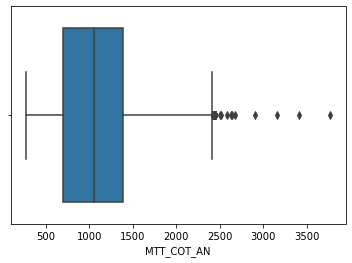

In [30]:
## Distribution du montant de cotisation

sns.boxplot(data=df_etude, x="MTT_COT_AN")

In [ ]:
## Distribution de l'age

fig = px.box(df_etude, x="Age")
fig.update_traces(boxmean=True)
fig.show()

In [46]:
## corrélation entre l'age et le montant de cotisation

spearmanr(df_etude["MTT_COT_AN"],df_etude["Age"], alternative="greater")

SignificanceResult(statistic=0.5854788292804954, pvalue=0.0)

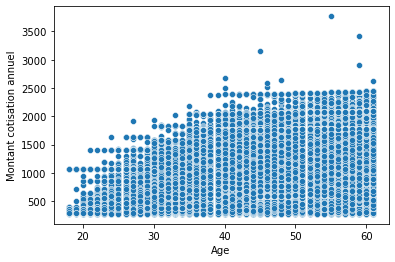

In [47]:
## Nuage de point  entre Age et le montant de cotisation

sns.scatterplot(data=df_etude, x="Age", y="MTT_COT_AN")

plt.xlabel("Age")

plt.ylabel("Montant cotisation annuel")

plt.show()

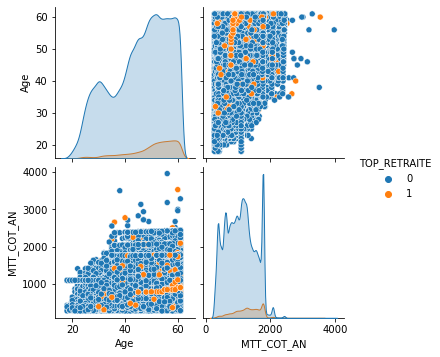

In [8]:
## adhérent ayant soucrit ou pas à la retraite en fonction de l'age et du montant

sns.pairplot(data=df_etude[["Age","MTT_COT_AN","TOP_RETRAITE"]], hue="TOP_RETRAITE")

In [12]:
Counter(df_etude["TOP_RETRAITE"])

Counter({'0': 608101, '1': 854})

In [273]:
df_etude["TYPE_COTISATION"].value_counts()

Taux        454406
Plafond      51885
Forfait      47403
Plancher     31512
Name: TYPE_COTISATION, dtype: int64

In [15]:
## test de khi-2 entre NAT_ACTIVITE et TYPE_COTISATION
## le premier element cest la statistique de test et le second élément c'est la p-value

chi2_contingency(pd.crosstab(df_etude["NAT_ACTIVITE"], df_etude["TYPE_COTISATION"]))[:2]

(129189.7289439463, 0.0)

In [48]:
## Calcul du v_cramer entre "NAT_ACTIVITE" et "TYPE_COTISATION"

nbre_mod_x=df_etude["NAT_ACTIVITE"].nunique()

nbre_mod_y=df_etude["TYPE_COTISATION"].nunique()

df1=pd.crosstab(df_etude["NAT_ACTIVITE"],df_etude["TYPE_COTISATION"])

chi2=chi2_contingency(df1)[0]

N=df_etude.shape[0]

round(np.sqrt(chi2/(N*(min(nbre_mod_x,nbre_mod_y)-1))),2)

0.33

Text(0, 0.5, 'Type de cotisation')

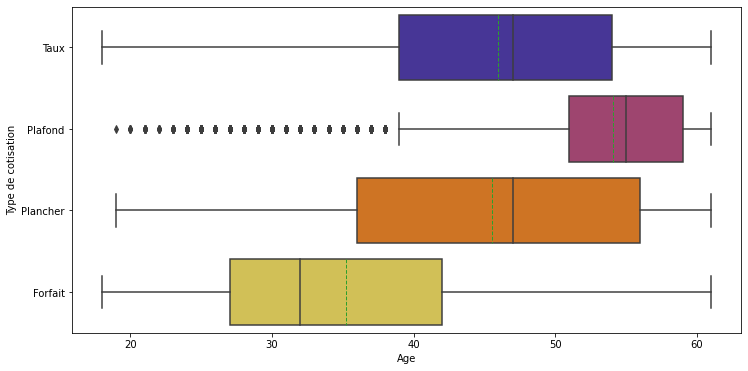

In [49]:
## Distribution de l'age en fonction du type

plt.figure(figsize=(12,6))
sns.boxplot(data=df_etude, y="TYPE_COTISATION",x="Age", orient='h',showmeans=True,palette="CMRmap",
            meanline=True)
plt.xlabel("Age")
plt.ylabel("Type de cotisation")

In [ ]:
## fait la même chose que précedemment

fig = px.box(df_etude, y="TYPE_COTISATION",x="Age")

fig.update_traces(boxmean=True)

fig.update_xaxes(title="Age")

fig.update_yaxes(title="Type de cotisation")

fig.show()

In [52]:
## fait le test de kruskal wallis pour tester s'il ya une difference significative d'age entre les differents
## types de cotisation

kruskal(df_etude.loc[(df_etude["TYPE_COTISATION"]=="Taux"),"Age"],
        df_etude.loc[(df_etude["TYPE_COTISATION"]=="Plafond"),"Age"],
       df_etude.loc[(df_etude["TYPE_COTISATION"]=="Forfait"),"Age"],
       df_etude.loc[(df_etude["TYPE_COTISATION"]=="Plancher"),"Age"])

KruskalResult(statistic=70411.00779980142, pvalue=0.0)

In [277]:
## réalise un test de Dunn avec ajustement de bonferroni pour relever les groupes où la difference 
## significative est averée

sp.posthoc_dunn([df_etude.loc[(df_etude["TYPE_COTISATION"]=="Taux"),"Age"],
        df_etude.loc[(df_etude["TYPE_COTISATION"]=="Plafond"),"Age"],
       df_etude.loc[(df_etude["TYPE_COTISATION"]=="Forfait"),"Age"],
       df_etude.loc[(df_etude["TYPE_COTISATION"]=="Plancher"),"Age"]], p_adjust = 'bonferroni')


1             2
1  1.000000e+00  1.946164e-84
2  1.946164e-84  1.000000e+00

In [256]:
import scikit_posthocs as sp

## test de kruskal wallis

kruskal(df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Actif"),"MTT_COT_AN"],
        df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Retraité"),"MTT_COT_AN"],
       df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Scolarité"),"MTT_COT_AN"])

### Test de Dunn

sp.posthoc_dunn([df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Actif"),"MTT_COT_AN"],
        df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Retraité"),"MTT_COT_AN"],
       df_etude.loc[(df_etude["NAT_ACTIVITE"]=="Scolarité"),"MTT_COT_AN"]], p_adjust = 'bonferroni')

### test shapiro

shapiro(df_etude["MTT_COT_AN"])

1    2    3
1  1.0  0.0  0.0
2  0.0  1.0  0.0
3  0.0  0.0  1.0

In [16]:
## Proportion des équipements

TOP = [col for col in df_etude.columns if col.startswith("TOP")]

df_agg = df_etude[TOP].agg(lambda x: round(x.value_counts(normalize=True),4)*100)

df_agg

df_agg = df_agg.T.reset_index()

#df_agg.columns.name = "Equipement"

TOP_ASSUR_VIE  TOP_DECES  TOP_CAM  TOP_TOUT_HABITAT  TOP_HABITAT_MGEN  \
0          99.83      97.08    99.39             81.92             88.29   
1           0.17       2.92     0.61             18.08             11.71   

   TOP_OBS  TOP_PIM  TOP_RETRAITE  
0    99.14    97.65         99.86  
1     0.86     2.35          0.14

In [21]:
#px.bar(df_agg, x="index",color="0",barmode="stack")

plot = go.Figure(data=[go.Bar(
    name = 'Non',
    x = df_agg["index"],
    y = df_agg["0"], text=list(map(lambda x: f"{x:.2f}%",list(df_agg["0"]))),textposition="auto"
   ),
                       go.Bar(
    name = 'Oui',
    x = df_agg["index"],
    y = df_agg["1"], text=list(map(lambda x: f"{x:.2f}%",list(df_agg["1"]))),textposition="auto"
   )
])

plot.update_layout(barmode='stack',legend_title_text='Equipé')

plot.update_yaxes(title="Pourcentage")

#plot.update_xaxes(title="Offres Additionnelles",tickvals=list(range(len(df_agg["index"]))), ticktext=["Tout Habitat","Tout Habitat MGEN","Assurance Retraite",
 #                                               "Assurance Décès","Prêt Installation MGEN","Assurance Obsèques","CAM","Assurance Vie",
 #                                                                                                     "Protection Juridique","Santé Animale"],
 #                categoryorder='max ascending')
    

plot.update_xaxes(title="Offres Additionnelles",categoryorder='max ascending')
                  
plot.show()

<AxesSubplot:ylabel='FORMULE'>

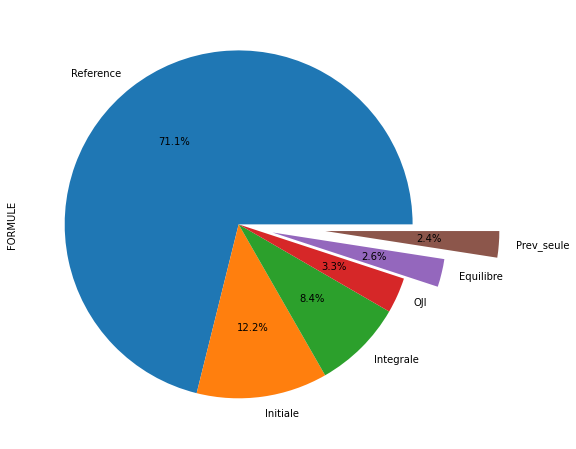

In [187]:
## proportion pour la "formule"

plt.figure(figsize=(10,8))
df_etude["FORMULE"].value_counts(normalize=True).plot(kind="pie",autopct="%.1f%%",explode=[0,0,0,0,0.2,0.5])

<div class='alert alert-info'>
    <center> <h3> Analyse Statistique</h3> </center>
</div>

In [9]:
## récupération de la classe(type) de chaque colonne

clas = []

for colonne in df_etude:
    
    binaire = "Binaire" if df_etude[colonne].nunique()==2 else "Non_Binaire"
    
    clas.append((colonne, str(type(df_etude[colonne][0]))[7:-1], binaire))
    
class_total = pd.DataFrame(clas, columns=["Colonne","Type","Nbre_elem"])

class_total.head()

Colonne           Type    Nbre_elem
0          NOIDE          'str'  Non_Binaire
1  TOP_ASSUR_VIE          'str'      Binaire
2            Age  'numpy.int64'  Non_Binaire
3      TOP_DECES          'str'      Binaire
4        TOP_CAM          'str'      Binaire

In [10]:
## liste des variables quantitatives

list(class_total.loc[class_total["Type"]!="'str'","Colonne"])

['Age',
 'Nbre_canaux_dispo',
 'Anciennete',
 'MTT_COT_AN',
 'INTER_MAIL',
 'TOTAL_INTER_CANAL',
 'Nbre_Camp_Fid',
 'Nbre_Camp_Multiequip',
 'Nbre_Total_Camp']

In [11]:
## Sortie du dataframe qui calcule le V_cramer entre les variables qualitatives

dummies_var = list(class_total.loc[class_total["Type"]=="'str'","Colonne"])[1:]  ## pour ne pas prendre le NOIDE

V_de_cramer =[]

for var1 in dummies_var:
    
    cramer = []
    
    nbre_mod_x=df_etude[var1].nunique()
    
    for var2 in dummies_var:
        
        nbre_mod_y=df_etude[var2].nunique()
        
        df1=pd.crosstab(df_etude[var1],df_etude[var2])
        
        chi2=chi2_contingency(df1)[0]
        
        N=df_etude.shape[0]
        
        cramer.append(round(np.sqrt(chi2/(N*(min(nbre_mod_x,nbre_mod_y)-1))),1))
        
    V_de_cramer.append(cramer)
        
df_cramer = pd.DataFrame(V_de_cramer, columns=dummies_var, index=dummies_var) 

df_cramer.head()

TOP_ASSUR_VIE  TOP_DECES  TOP_CAM  TOP_TOUT_HABITAT  \
TOP_ASSUR_VIE               1.0        0.0      0.0               0.0   
TOP_DECES                   0.0        1.0      0.0               0.0   
TOP_CAM                     0.0        0.0      1.0               0.0   
TOP_TOUT_HABITAT            0.0        0.0      0.0               1.0   
TOP_HABITAT_MGEN            0.0        0.0      0.0               0.8   

                  TOP_HABITAT_MGEN  TOP_OBS  TOP_PIM  TOP_RETRAITE  \
TOP_ASSUR_VIE                  0.0      0.0      0.0           0.0   
TOP_DECES                      0.0      0.0      0.0           0.0   
TOP_CAM                        0.0      0.1      0.0           0.0   
TOP_TOUT_HABITAT               0.8      0.0      0.1           0.0   
TOP_HABITAT_MGEN               1.0      0.0      0.0           0.0   

                  NAT_ACTIVITE  Contact_Tel  Contact_Mail  Contact_SMS  \
TOP_ASSUR_VIE              0.0          0.0           0.0          0.0   
TOP_DECES                  0.0          0.0           0.0          0.0   
TOP_CAM                    0.0          0.0           0.0          0.0   
TOP_TOUT_HABITAT           0.1          0.0           0.0          0.0   
TOP_HABITAT_MGEN           0.1          0.0           0.0          0.0   

                  Contact_Cour  FORMULE  CODSEX  COUVRE_BE  COUVRE_BC  \
TOP_ASSUR_VIE              0.0      0.0     0.0        0.0        0.0   
TOP_DECES                  0.1      0.2     0.0        0.0        0.0   
TOP_CAM                    0.0      0.0     0.0        0.0        0.0   
TOP_TOUT_HABITAT           0.1      0.2     0.0        0.1        0.0   
TOP_HABITAT_MGEN           0.0      0.1     0.0        0.1        0.0   

                  TYPE_COTISATION  REGION  Freq_moy_email/mois_disc  \
TOP_ASSUR_VIE                 0.0     0.0                       0.0   
TOP_DECES                     0.0     0.0                       0.0   
TOP_CAM                       0.0     0.0                       0.0   
TOP_TOUT_HABITAT              0.2     0.1                       0.0   
TOP_HABITAT_MGEN              0.1     0.1                       0.0   

                  Freq_moy_Cour/mois_disc  Freq_moy_SMS/mois_disc  \
TOP_ASSUR_VIE                         0.0                     0.0   
TOP_DECES                             0.1                     0.0   
TOP_CAM                               0.0                     0.0   
TOP_TOUT_HABITAT                      0.1                     0.0   
TOP_HABITAT_MGEN                      0.1                     0.0   

                  Freq_moy_TEL/mois_disc  Freq_moy_Camp/mois_disc  \
TOP_ASSUR_VIE                        0.0                      0.0   
TOP_DECES                            0.0                      0.0   
TOP_CAM                              0.0                      0.0   
TOP_TOUT_HABITAT                     0.0                      0.0   
TOP_HABITAT_MGEN                     0.0                      0.0   

                  chgt_tr_cotis_n-1_n  chgt_tr_cotis_n-2_n-1  \
TOP_ASSUR_VIE                     0.0                    0.0   
TOP_DECES                         0.1                    0.1   
TOP_CAM                           0.0                    0.0   
TOP_TOUT_HABITAT                  0.1                    0.1   
TOP_HABITAT_MGEN                  0.1                    0.1   

                  evol_cotis_n-1_n  evol_cotis_n-2_n-1  nb_evolution  \
TOP_ASSUR_VIE                  0.0                 0.0           0.0   
TOP_DECES                      0.1                 0.1           0.1   
TOP_CAM                        0.0                 0.0           0.0   
TOP_TOUT_HABITAT               0.1                 0.1           0.1   
TOP_HABITAT_MGEN               0.1                 0.1           0.1   

                  nb_baisse  PROPO_Courrier_disc  PROPO_FACEAFACE_disc  \
TOP_ASSUR_VIE           0.0                  0.0                   0.1   
TOP_DECES               0.1                  0.0   

In [12]:
## Calcul de la statistique de kolmogorov entre la variable cible qualitative et les variables quantitatives

def kolmogorov(df, cible, liste_var):
    
    liste_ks = []
    
    for var in liste_var:
        
        liste_ks.append(kstest(df.loc[(df[cible]=="0"),var],df.loc[(df[cible]=="1"),var]))
        
    return pd.DataFrame(liste_ks, columns=[cible,"P_value"], index=liste_var)

## Appel de la fonction

df_kolmogorov = kolmogorov(df_etude, "TOP_RETRAITE", list(class_total.loc[class_total["Type"]!="'str'","Colonne"]))

df_kolmogorov

TOP_RETRAITE        P_value
Age                       0.508954  2.262857e-205
Nbre_canaux_dispo         0.117959   8.474141e-11
Anciennete                0.382434  1.060379e-112
MTT_COT_AN                0.368397  2.451382e-104
INTER_MAIL                0.119584   4.364119e-11
TOTAL_INTER_CANAL         0.086314   5.603627e-06
Nbre_Camp_Fid             0.070507   3.928757e-04
Nbre_Camp_Multiequip      0.087319   4.153335e-06
Nbre_Total_Camp           0.051036   2.268939e-02

In [13]:
## Ordonner de manière décroissante de statistique de kolmogorov

df_kolmogorov.sort_values(by="TOP_RETRAITE", ascending=False)

TOP_RETRAITE        P_value
Age                       0.508954  2.262857e-205
Anciennete                0.382434  1.060379e-112
MTT_COT_AN                0.368397  2.451382e-104
INTER_MAIL                0.119584   4.364119e-11
Nbre_canaux_dispo         0.117959   8.474141e-11
Nbre_Camp_Multiequip      0.087319   4.153335e-06
TOTAL_INTER_CANAL         0.086314   5.603627e-06
Nbre_Camp_Fid             0.070507   3.928757e-04
Nbre_Total_Camp           0.051036   2.268939e-02

In [36]:
df_cramer[df_cramer["TOP_RETRAITE"].between(0.01,0.1)]

TOP_ASSUR_VIE  TOP_DECES  TOP_CAM  \
PROPO_TELEPHONE_disc                   0.1        0.0      0.0   
Devis_Epargne_retraite_disc            0.1        0.0      0.0   

                             TOP_TOUT_HABITAT  TOP_HABITAT_MGEN  TOP_OBS  \
PROPO_TELEPHONE_disc                      0.0               0.0      0.0   
Devis_Epargne_retraite_disc               0.0               0.0      0.0   

                             TOP_PIM  TOP_RETRAITE  NAT_ACTIVITE  Contact_Tel  \
PROPO_TELEPHONE_disc             0.0           0.1           0.0          0.0   
Devis_Epargne_retraite_disc      0.0           0.1           0.0          0.0   

                             ...  Devis_Epargne_retraite_disc  Devis_PIM_disc  \
PROPO_TELEPHONE_disc         ...                          0.3             0.2   
Devis_Epargne_retraite_disc  ...                          1.0             0.1   

                             Nbre_Devis_Hors_Retr_disc  \
PROPO_TELEPHONE_disc                               0.4   
Devis_Epargne_retraite_disc                        0.1   

                             Nbre_Equip_Hors_Retr_disc  \
PROPO_TELEPHONE_disc                               0.0   
Devis_Epargne_retraite_disc                        0.0   

                             Nbre_canaux_Devis_disc  NB_RECLA_disc  \
PROPO_TELEPHONE_disc                            0.2            0.0   
Devis_Epargne_retraite_disc                     0.2            0.0   

                             INTER_COURRIER_disc  INTER_SMS_disc  \
PROPO_TELEPHONE_disc                         0.0             0.0   
Devis_Epargne_retraite_disc                  0.0             0.0   

                             INTER_TEL_disc  Nbre_Camp_Conq_disc  
PROPO_TELEPHONE_disc                    0.1                  0.0  
Devis_Epargne_retraite_disc             0.0                  0.0  

[2 rows x 49 columns]

In [14]:
## Variable avec le v_cramer plus grand avec la variable cible

fig = px.bar(df_cramer[df_cramer["TOP_RETRAITE"].between(0.01,0.1)],x="TOP_RETRAITE", text_auto=True)

fig.update_xaxes(title="V-cramer")

fig.update_yaxes(title="Variables")

fig.show()

In [15]:
## Variable avec la statistique de kolmogorov plus grande avec la variable cible

fig = px.bar(df_kolmogorov[df_kolmogorov["P_value"]<.05],x="TOP_RETRAITE", text_auto='.2f')

fig.update_yaxes(title="Variables",categoryorder='total ascending',tickvals=list(range(8,-1,-1)),
                 ticktext=["Âge","Ancienneté",
                "Montant annuelle cotisation","Nombre total de contact email reçu","Nombre de canaux de contact disponible","Nombre de campagne de multi-équipements",
                "Nombre total de contact de campagne", "Nombre de campagne de Fidélisation reçu","Nombre total de campagne reçu hors retraite"
                ])

fig.update_xaxes(title="Statistique de Kolmogorov")

fig.show()

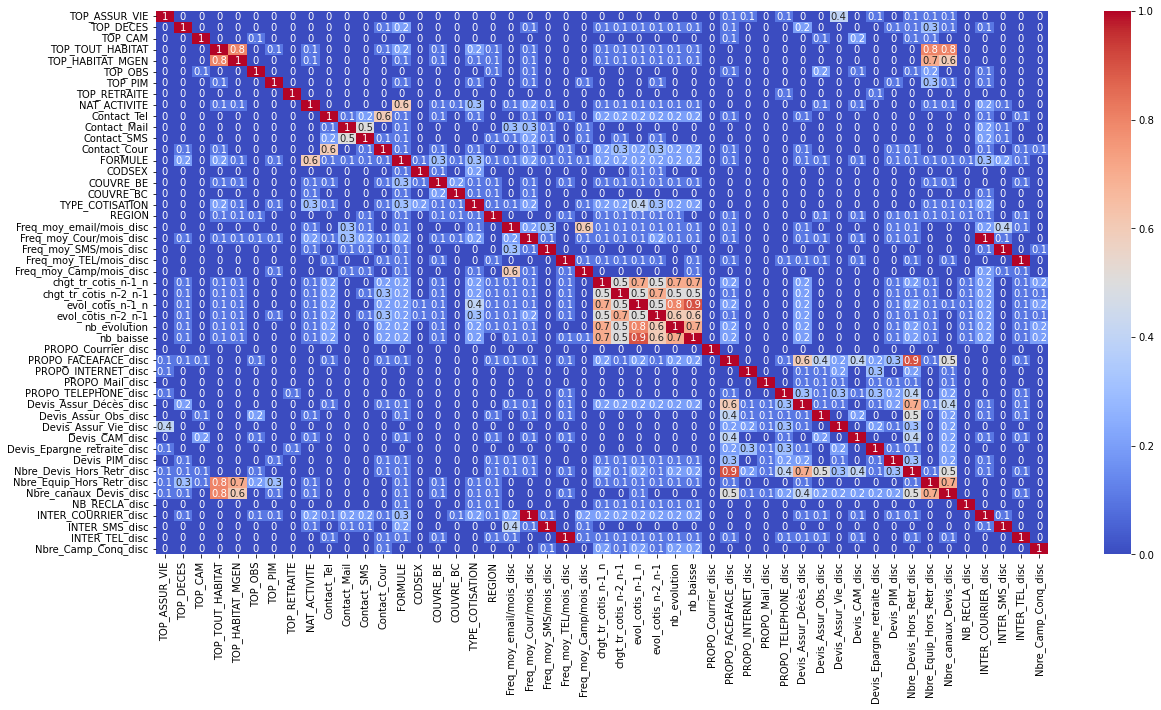

In [40]:
## plot heatmap avec la matrice du v_cramer

plt.rcParams["figure.figsize"]=[20,10]

sns.heatmap(df_cramer,annot=True, cmap="coolwarm")

plt.show()

<div class='alert alert-info'>
    <center> <h3> Clustering de variables</h3> </center>
</div>

In [16]:
# récupération des variables avec un v_cramer>0.5

col_cramer = []
for col1 in df_cramer.columns:
    for col2 in df_cramer.columns:
        if col1!=col2 and df_cramer.loc[col1,col2]>0.5:
            col_cramer.append(col1)
            
## dédoublonnages des variables
col_cramer = list(set(col_cramer))

In [17]:
## dataframe de v_cramer des variables avec v_cramer>0.5

df_cramer_associe = df_cramer.loc[col_cramer,col_cramer].copy()

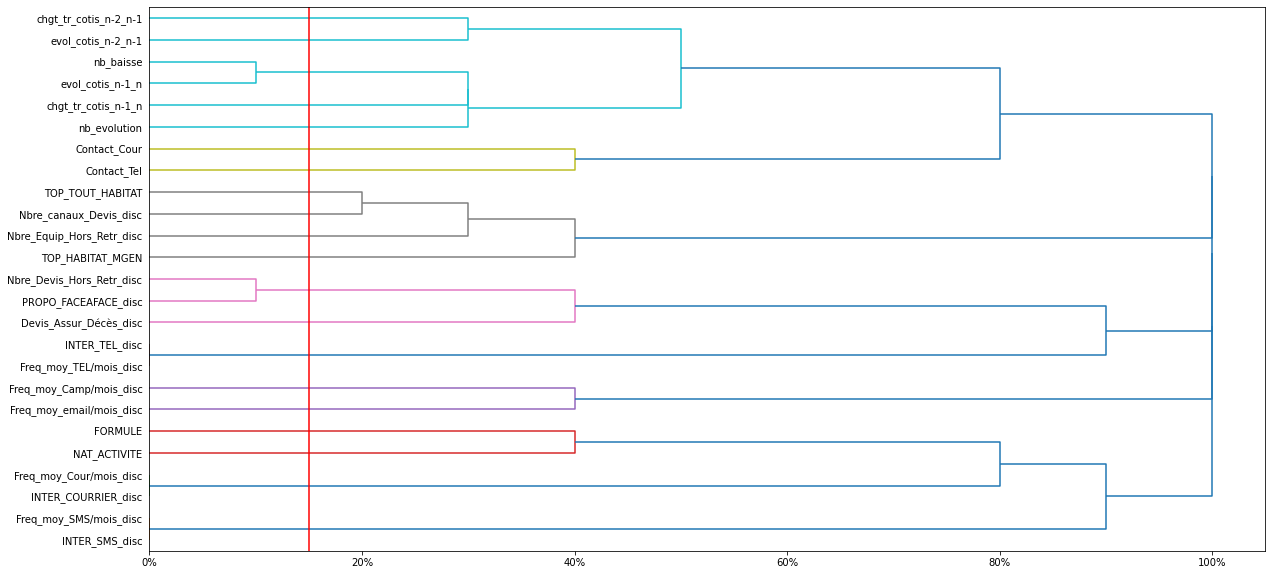

In [26]:
## clustering de variables avec seuil de 0.15

plt.rcParams["figure.figsize"]=[20,10]

figure = pyplot.figure()

axes = figure.add_subplot(111)

dist = squareform(1-abs(df_cramer_associe))

corr_linkage = hierarchy.complete(dist)

dendro = hierarchy.dendrogram(
    corr_linkage,
    orientation="right",
    labels=df_cramer_associe.columns
)

plt.axvline(0.15, c='r')

positions = [0, 0.2, 0.4, .6,.8, 1]

labels = ['0%','20%','40%','60%','80%','100%']

axes.xaxis.set_major_locator(ticker.FixedLocator(positions))

axes.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

plt.show()

In [21]:
# Définition du seuil de corrélation

threshold_for_cluster_creation = 0.15

var = df_cramer_associe.columns

# Récupération des clusters à partir de la hiérarchie

cluster_ids = hierarchy.fcluster(corr_linkage, threshold_for_cluster_creation, criterion='distance')

cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
clusters = [ list(v) for v in cluster_id_to_feature_ids.values() if len(v) >1]

clusters_col = [list(var[i] for i in v) for v in clusters]

# On ne conservera que la variable la plus associée à la variable cible dans chaque cluster, les autres sont retirées

print(f"les clusters au seuil de {threshold_for_cluster_creation} sont \n\n {clusters_col}")

les clusters au seuil de 0.15 sont 

 [['PROPO_FACEAFACE_disc', 'Nbre_Devis_Hors_Retr_disc'], ['Freq_moy_TEL/mois_disc', 'INTER_TEL_disc'], ['evol_cotis_n-1_n', 'nb_baisse'], ['INTER_COURRIER_disc', 'Freq_moy_Cour/mois_disc'], ['INTER_SMS_disc', 'Freq_moy_SMS/mois_disc']]


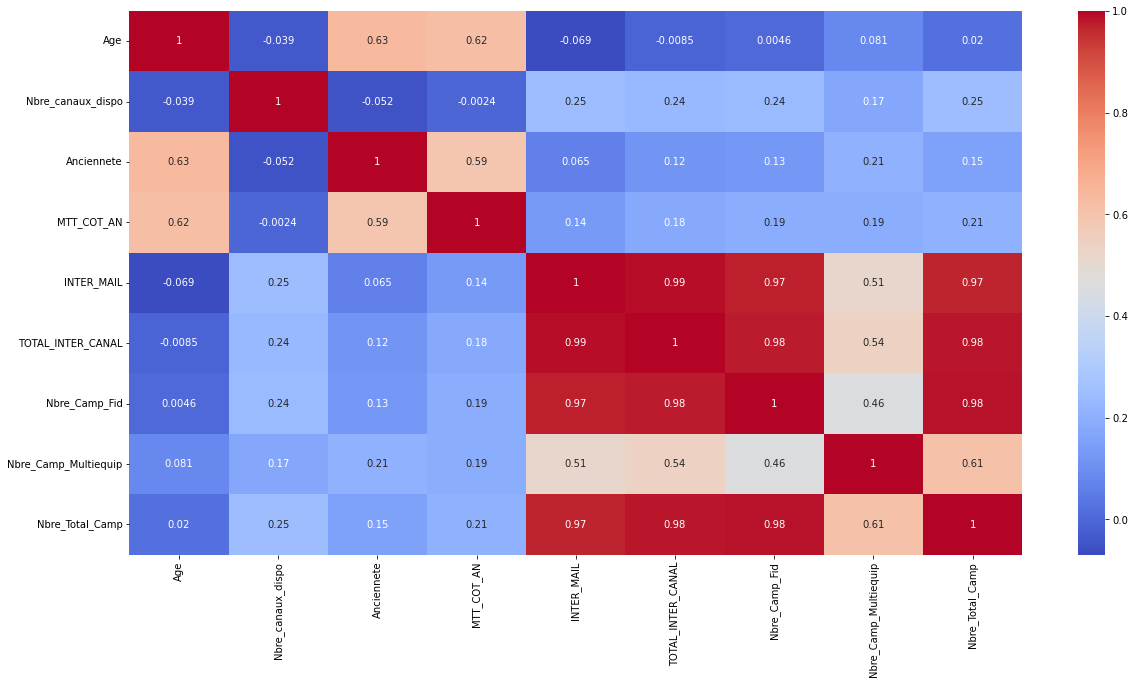

In [23]:
## Variables continue

int_var = list(class_total.loc[class_total["Type"]!="'str'","Colonne"])

df = df_etude[int_var].corr().copy()

plt.rcParams["figure.figsize"]=[20,10]

sns.heatmap(df,annot=True, cmap="coolwarm")

plt.show()

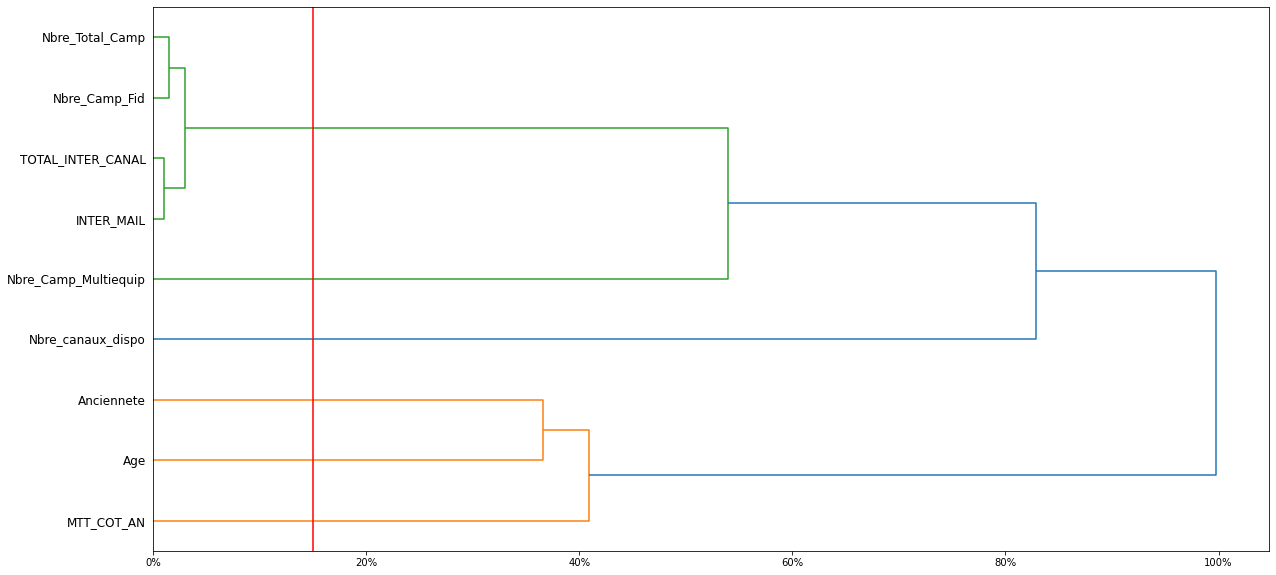

In [25]:
## Clustering de variable continue

figure = pyplot.figure()

axes = figure.add_subplot(111)

dist = squareform(1-abs(df))

corr_linkage = hierarchy.complete(dist)

dendro = hierarchy.dendrogram(
    corr_linkage,
    orientation="right",
    labels=df.columns
)
plt.axvline(0.15, c='r')

positions = [0, 0.2, 0.4, .6,.8, 1]

labels = ['0%','20%','40%','60%','80%','100%']

axes.xaxis.set_major_locator(ticker.FixedLocator(positions))

axes.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

plt.show()

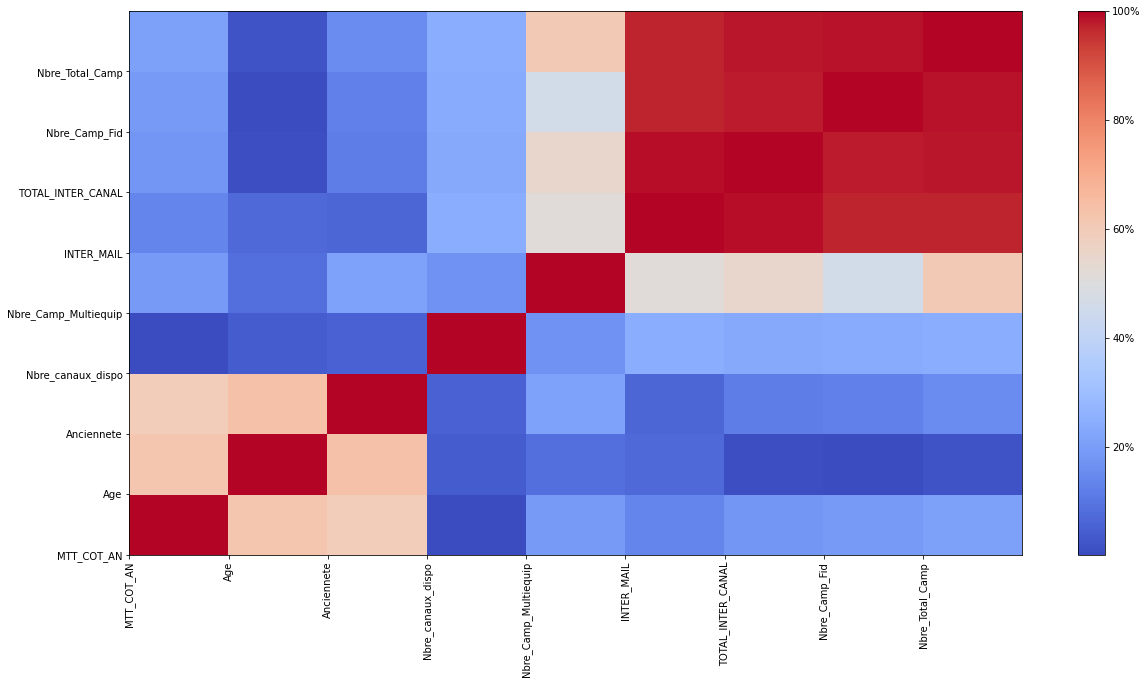

In [55]:
## regroupement des variables correlées

corr1=df.to_numpy()

fig = plt.figure()

ax = fig.add_subplot(1,1,1)

plot = ax.pcolor(abs(corr1[dendro["leaves"],:][:,dendro["leaves"]]), cmap="coolwarm")

dendro_idx = np.arange(0, len(dendro["ivl"]))

ax.set_xticks(dendro_idx)

ax.set_yticks(dendro_idx)

ax.set_xticklabels(dendro["ivl"], rotation='vertical')

ax.set_yticklabels(dendro["ivl"])

cbar = fig.colorbar(plot, format=ticker.PercentFormatter(xmax=1))

In [27]:
### fonction pour la sélection des variables

def selection_variable(df,liste_var,cible,type_var):
    """
    Cette fonction permettra de selectionner les variables à supprimer parmi un groupe de variables les
    plus correlées/associées et ne garder que celle qui est plus correlée/associé à la variable cible.
    NB: type_var ne doit prendre que les valeurs "quali", "quanti"
    """
    
    var_sup = []
    
    if type_var=="quali":
    
        for group in liste_var:

            stat = []

            for var in group:

                stat.append(df.loc[cible,var])

            non_sup = stat.index(max(stat))  ## index variable à ne pas supprimer

            del(group[non_sup])

            var_sup = var_sup + group
            
    else:
        
        for group in liste_var:
            
            stat = []
            
            for var in group:
                
                stat.append(kstest(df.loc[(df[cible]=="0"),var],df.loc[(df[cible]=="1"),var])[0])
                
            non_sup = stat.index(max(stat))  ## index variable à ne pas supprimer
            
            del(group[non_sup])
            
            var_sup = var_sup+group
         
    return var_sup

In [28]:
### Liste des variables quali ou quanti à supprimer
## Penser à modifier les variables quanti ou quali les plus correlées/associées au seuil de 15% s'il arrive que ça change

liste_var_group = [['Freq_moy_TEL/mois_disc', 'INTER_TEL_disc'], ['PROPO_FACEAFACE_disc', 'Nbre_Devis_Hors_Retr_disc'], ['INTER_COURRIER_disc', 'Freq_moy_Cour/mois_disc'],
                   ['evol_cotis_n-1_n', 'nb_baisse'], ['INTER_SMS_disc', 'Freq_moy_SMS/mois_disc']]

liste_quali_supp = selection_variable(df_cramer,liste_var_group,"TOP_RETRAITE","quali")

liste_quanti_supp = selection_variable(df_etude,[["INTER_MAIL","Nbre_Total_Camp","Nbre_Camp_Fid",
                                                   "TOTAL_INTER_CANAL"]],"TOP_RETRAITE","quanti")

In [29]:
## Liste des variables à supprimer

liste_quanti_supp+liste_quali_supp

['Nbre_Total_Camp',
 'Nbre_Camp_Fid',
 'TOTAL_INTER_CANAL',
 'INTER_TEL_disc',
 'Nbre_Devis_Hors_Retr_disc',
 'Freq_moy_Cour/mois_disc',
 'nb_baisse',
 'Freq_moy_SMS/mois_disc']

In [30]:
## Variable à garder

int_var=['NOIDE', 'Age', 'Nbre_canaux_dispo', 'Anciennete', 'MTT_COT_AN', 'Nbre_Camp_Multiequip', 'Nbre_Total_Camp']

## Préprocessing pour la modélisation

In [224]:
## Export pour enregistrer le fichier

#df_etude_bis.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\df_etude.csv", index=False, encoding='mbcs')

In [31]:
### suppression des variables trop correlées

df_etude.drop(liste_quanti_supp+liste_quali_supp, axis=1, inplace = True)

In [61]:
### suppression des variables trop correlées sur le jeu de deployement

df_val_2022.drop(liste_quanti_supp+liste_quali_supp, axis=1, inplace = True)

In [32]:
## transformation des variables des équipements en str

Top = [col for col in df_etude.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    df_etude[col] = df_etude[col].astype(str)
    
df_etude["COUVRE_BE"] = df_etude["COUVRE_BE"].astype(float).astype(int).astype(str)

df_etude["COUVRE_BC"] = df_etude["COUVRE_BC"].astype(float).astype(int).astype(str)

In [63]:
## transformation des variables des équipements en str

Top = [col for col in df_val_2022.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    df_val_2022[col] = df_val_2022[col].astype(str)
    
df_val_2022["COUVRE_BE"] = df_val_2022["COUVRE_BE"].astype(float).astype(int).astype(str)

df_val_2022["COUVRE_BC"] = df_val_2022["COUVRE_BC"].astype(float).astype(int).astype(str)

In [34]:
## Division en jeu d'apprentissage 70% et jeu de validation 30%

X1=df_etude.drop(["TOP_RETRAITE","Devis_Epargne_retraite_disc"], axis=1).copy()

y1 = df_etude["TOP_RETRAITE"].copy()

x_train_nc, x_val, y_train_nc, y_val = train_test_split(X1,y1,test_size=0.3,random_state=42)

x_train_nc.reset_index(drop=True, inplace=True)

x_val.reset_index(drop=True, inplace=True)

df_val_2022.reset_index(drop=True, inplace=True)

print("taille du jeu d\'entrainement",x_train_nc.shape,"\n")

print("taille du jeu de validation",x_val.shape,"\n")

taille du jeu d'entrainement (426268, 49) 

taille du jeu de validation (182687, 49) 



In [66]:
## récupération de la classe de chaque colonne

def recup_class_col(df):
    """
    Cette fonction va recupérer la classe de chaque colonne contenu dans le dataframe df
    """
    clas = []

    for colonne in df:

        binaire = "Binaire" if df[colonne].nunique()==2 else "Non_Binaire"

        clas.append((colonne, str(type(df[colonne][0]))[7:-1], binaire))

    return pd.DataFrame(clas, columns=["Colonne","Type","Nbre_elem"])

In [67]:
## transformation des variables en qualitatives en dummies variables

def get_dummies_var(df,df_class_total, int_var):
    """
    Cette fonction va recupérer toutes les variables qualitatives du jeux de données et les transformer en dummie-variable
    """
    
    dummies_var = list(df_class_total.loc[df_class_total["Type"]=="'str'","Colonne"])[1:]

    int_var =list(df_class_total.loc[df_class_total["Type"]!="'str'","Colonne"])

    var_binaire = list(df_class_total.loc[df_class_total["Nbre_elem"]=="Binaire","Colonne"])

    df1 = pd.get_dummies(df[dummies_var], prefix=dummies_var)

    for colonne in var_binaire:

        try:

            df1.drop(colonne+"_0", axis=1, inplace=True)

            df1.rename(columns={colonne+"_1":colonne}, inplace=True)

        except KeyError:

            try:

                df1.drop(colonne+"_Aucun", axis=1, inplace=True)

            except KeyError:

                try:

                    df1.drop(colonne+"_F", axis=1, inplace=True)

                    df1.rename(columns={colonne+"_M":"SEXE"}, inplace=True)

                except KeyError:

                    df1.drop(colonne+"_Aucune", axis=1, inplace=True)

        #finally:
        #    print("le groupe try except est terminé")
            
    ### ici on regrouper les variables dummies et les variables quanti
    
    df_etude_dummy = pd.concat([df[["NOIDE"]+int_var],df1], axis=1)
    
    return df_etude_dummy

## SEXE=1 si masculin et 0 si femme

In [68]:
## Appel des deux fonctions précédentes pour transformer les données de train et de validation

x_train_nc = get_dummies_var(x_train_nc,recup_class_col(x_train_nc),int_var)

x_val = get_dummies_var(x_val,recup_class_col(x_val),int_var)

df_val_2022 = get_dummies_var(df_val_2022,recup_class_col(df_val_2022),int_var)

In [69]:
## On verifie que toutes les colonnes présentent dans le jeu de données d'apprentissage est bien présent dans le jeu de 
## validation si oui il faudra supprimer cette colonne car cela signifirait qu'un seul individu possède une valuer non nulle
## sur celle-ci

print(len(x_train_nc)==len(x_val))

for col in x_val:
    
    if col not in x_train_nc.columns:
        
        print(col)

False
REGION_S. E. M.


In [70]:
## Suppression de la colonne en trop dans la base de validation

x_val.drop("REGION_S. E. M.", axis=1, inplace=True)

df_val_2022.drop("REGION_S. E. M.", axis=1, inplace=True)

### Modélisation 

In [35]:
## Suréchantillonage aleatoire (Boostrap)

counter = Counter(y_train_nc)

print(counter)

rus = RandomOverSampler(random_state=42)

X_res_over, y_res_over = rus.fit_resample(x_train_nc, y_train_nc)

counter = Counter(y_res_over)

print(counter)

Counter({'0': 425668, '1': 600})
Counter({'0': 425668, '1': 425668})


In [36]:
## Division en jeu d'apprentissage 70% et jeu de test 30%

x_train, x_test, y_train, y_test = train_test_split(X_res_over,y_res_over,test_size=0.3,random_state=42)

y_train = y_train.astype(int)

y_test = y_test.astype(int)

y_val = y_val.astype(int)

print("taille du jeu d\'entrainement",x_train.shape,"\n")

print("taille du jeu de test",x_test.shape,"\n")

taille du jeu d'entrainement (595935, 49) 

taille du jeu de test (255401, 49) 



In [73]:
optb = OptimalBinning(dtype="numerical", solver="cp")

def optimal_Binning(df1,df2,name,cible):
    """
    Cette fonction permettra de faire la discrétisation supervisée des variables quantitatives en fonction de la variable
    de la manière la plus optimale possible (en basant sur le critère de gini, le v-cramer, ...)
    """
    
    optb.fit(df1[name].values, cible.values)
    
    name_woe_train = optb.transform(df1[name].values, metric="bins")
    
    name_woe_test = optb.transform(df2[name].values, metric="bins")
    
    return (name_woe_train,name_woe_test)


def supprime_col(df):
    """
    Cette fonction supprime les variables continues qui ont été supprimés précédement 
    si la discrétisation de la variable contient au moins deux classes
    """
    
    disc = [col for col in df.columns if col.endswith("_disc")]

    for col in disc:

        if df[col].nunique()==1:

            df.drop(col,axis=1, inplace=True)

        else:

            df.drop(col[:-5],axis=1, inplace=True)
            
    return df

In [74]:
## discrétisation des variable continues en utilisant les fonctions précédentes

int_var=['Age', 'Nbre_canaux_dispo', 'Anciennete', 'MTT_COT_AN', 'Nbre_Camp_Multiequip', 'INTER_MAIL']

for col in int_var:
    
    x_train[col+"_disc"] = optimal_Binning(x_train,x_test,col,y_train)[0]
    
    x_test[col+"_disc"] = optimal_Binning(x_train,x_test,col,y_train)[1]
    
    x_val[col+"_disc"] = optimal_Binning(x_train,x_val,col,y_train)[1]
    
    df_val_2022[col+"_disc"] = optimal_Binning(x_train,df_val_2022,col,y_train)[1]
    
x_train =  supprime_col(x_train)   

x_test =  supprime_col(x_test) 

x_val =  supprime_col(x_val)

df_val_2022 =  supprime_col(df_val_2022)

In [75]:
## tête du fichier

x_train.head()

NOIDE  TOP_ASSUR_VIE  TOP_DECES  TOP_CAM  TOP_TOUT_HABITAT  \
809193  0108290021              0          0        0                 0   
630551  0107504896              0          0        0                 0   
39349   0102149583              0          0        0                 0   
446782  0107821580              0          1        0                 0   
606800  0108925417              0          1        0                 0   

        TOP_HABITAT_MGEN  TOP_OBS  TOP_PIM  NAT_ACTIVITE_Actif  \
809193                 0        0        0                   1   
630551                 0        0        1                   1   
39349                  0        0        0                   1   
446782                 0        0        0                   1   
606800                 0        0        0                   1   

        NAT_ACTIVITE_Retraité  NAT_ACTIVITE_Scolarité  Contact_Tel  \
809193                      0                       0            1   
630551                      0                       0            1   
39349                       0                       0            1   
446782                      0                       0            1   
606800                      0                       0            1   

        Contact_Mail  Contact_SMS  Contact_Cour  FORMULE_Equilibre  \
809193             1            1             1                  0   
630551             1            1             1                  0   
39349              1            0             1                  0   
446782             1            1             1                  0   
606800             1            1             1                  0   

        FORMULE_Initiale  FORMULE_Integrale  FORMULE_OJI  FORMULE_Prev_seule  \
809193                 1                  0            0                   0   
630551                 0                  0            0                   0   
39349                  0                  0            0                   0   
446782                 0                  0            0                   0   
606800                 1                  0            0                   0   

        FORMULE_Reference  SEXE  COUVRE_BE  COUVRE_BC  \
809193                  0     1          0          0   
630551                  1     0          0          0   
39349                   1     0          1          0   
446782                  1     0          0          0   
606800                  0     0          0          0   

        TYPE_COTISATION_Forfait  TYPE_COTISATION_Plafond  \
809193                        0                        0   
630551                        0                        0   
39349                         0                        1   
446782                        0                        0   
606800                        0                        0   

        TYPE_COTISATION_Plancher  TYPE_COTISATION_Taux  REGION_Aquitaine  \
809193                         0                     1                 0   
630551                         0                     1                 0   
39349                          0                     0                 0   
446782                         0                     1                 0   
606800                         0                     1                 0   

        REGION_Auvergne  REGION_Bourgogne Franche Comté  REGION_Bretagne   \
809193                0                               0                 1   
630551                0                               0                 0   
39349                 0                               0                 0   
446782                0                               0                 0   
606800                0                               1                 0   

        REGION_Centre  REGION_DFA  REGION_Grand Est  REGION_Hauts De France  \
809193              0           0                 0                       0   
630551              0           0                 1         

In [76]:
## Transformation des variables discrétiser en dummies variables sur le jeu d'apprentissage

var_dummies = ["Nbre_canaux_dispo_disc","Age_disc",  
              "Anciennete_disc","MTT_COT_AN_disc","INTER_MAIL_disc","Nbre_Camp_Multiequip_disc"]

df = pd.get_dummies(x_train[var_dummies], prefix=var_dummies)

var_restant = list(set(list(x_train.columns))-set(var_dummies))

x_train = pd.concat([x_train[var_restant],df], axis=1)

x_train.head()

TOP_TOUT_HABITAT  Devis_CAM_disc_Au_moins_1  FORMULE_Prev_seule  \
809193                 0                          0                   0   
630551                 0                          0                   0   
39349                  0                          0                   0   
446782                 0                          0                   0   
606800                 0                          0                   0   

        REGION_Rhône Alpes  COUVRE_BC  Freq_moy_Camp/mois_disc_1_Camp/mois  \
809193                   0          0                                    1   
630551                   0          0                                    0   
39349                    0          0                                    1   
446782                   0          0                                    1   
606800                   0          0                                    1   

        evol_cotis_n-1_n_stable  Devis_Assur_Vie_disc_Au_moins_1  \
809193                        0                                0   
630551                        0                                0   
39349                         1                                0   
446782                        0                                0   
606800                        1                                0   

        chgt_tr_cotis_n-1_n_1  FORMULE_Reference  \
809193                      0                  0   
630551                      0                  1   
39349                       0                  1   
446782                      1                  1   
606800                      0                  0   

        Nbre_Camp_Conq_disc_Au_moins_1  PROPO_INTERNET_disc_Au_moins_1  \
809193                               0                               0   
630551                               0                               0   
39349                                0                               0   
446782                               0                               0   
606800                               0                               0   

        evol_cotis_n-2_n-1_stable  TYPE_COTISATION_Taux  \
809193                          0                     1   
630551                          0                     1   
39349                           0                     0   
446782                          0                     1   
606800                          0                     1   

        Freq_moy_email/mois_disc_1_mail/mois  TOP_HABITAT_MGEN  \
809193                                     1                 0   
630551                                     1                 0   
39349                                      0                 0   
446782                                     1                 0   
606800                                     1                 0   

        Freq_moy_TEL/mois_disc_Aucun_TEL/mois  \
809193                                      1   
630551                                      0   
39349                                       1   
446782                                      1   
606800                                      1   

        Freq_moy_email/mois_disc_ciblé_1_fois  TOP_ASSUR_VIE  \
809193                                      0              0   
630551                                      0              0   
39349                                       0              0   
446782                                      0              0   
606800                                      0              0   

        REGION_ILE DE France  REGION_Aquitaine  REGION_Pays de la Loire   \
809193                     0                 0                         0   
630551                     0                 0                         0   
39349                      1                 0                         0   
446782                     0                 0                         0   
606800                     0                 0                         0   

        nb_evolution_1_et_plus  

In [77]:
## Transformation des variables discrétiser en dummies variables sur le jeu de test

var_dummies = ["Nbre_canaux_dispo_disc","Age_disc",  
              "Anciennete_disc","MTT_COT_AN_disc","INTER_MAIL_disc","Nbre_Camp_Multiequip_disc"]

df = pd.get_dummies(x_test[var_dummies], prefix=var_dummies)

var_restant = list(set(list(x_test.columns))-set(var_dummies))

x_test = pd.concat([x_test[var_restant],df], axis=1)

x_test.head()

TOP_TOUT_HABITAT  Devis_CAM_disc_Au_moins_1  FORMULE_Prev_seule  \
412790                 0                          0                   0   
632242                 0                          0                   0   
113425                 0                          0                   0   
78357                  0                          0                   0   
377044                 0                          0                   0   

        REGION_Rhône Alpes  COUVRE_BC  Freq_moy_Camp/mois_disc_1_Camp/mois  \
412790                   0          1                                    1   
632242                   0          0                                    0   
113425                   0          0                                    1   
78357                    0          0                                    1   
377044                   0          1                                    1   

        evol_cotis_n-1_n_stable  Devis_Assur_Vie_disc_Au_moins_1  \
412790                        0                                0   
632242                        0                                0   
113425                        0                                0   
78357                         0                                0   
377044                        0                                0   

        chgt_tr_cotis_n-1_n_1  FORMULE_Reference  \
412790                      0                  1   
632242                      0                  0   
113425                      0                  1   
78357                       0                  1   
377044                      0                  1   

        Nbre_Camp_Conq_disc_Au_moins_1  PROPO_INTERNET_disc_Au_moins_1  \
412790                               0                               0   
632242                               0                               0   
113425                               0                               0   
78357                                0                               0   
377044                               0                               0   

        evol_cotis_n-2_n-1_stable  TYPE_COTISATION_Taux  \
412790                          0                     1   
632242                          0                     0   
113425                          0                     1   
78357                           0                     1   
377044                          0                     0   

        Freq_moy_email/mois_disc_1_mail/mois  TOP_HABITAT_MGEN  \
412790                                     1                 0   
632242                                     0                 0   
113425                                     1                 0   
78357                                      1                 0   
377044                                     1                 0   

        Freq_moy_TEL/mois_disc_Aucun_TEL/mois  \
412790                                      1   
632242                                      1   
113425                                      1   
78357                                       1   
377044                                      1   

        Freq_moy_email/mois_disc_ciblé_1_fois  TOP_ASSUR_VIE  \
412790                                      0              0   
632242                                      1              0   
113425                                      0              0   
78357                                       0              0   
377044                                      0              0   

        REGION_ILE DE France  REGION_Aquitaine  REGION_Pays de la Loire   \
412790                     0                 0                         0   
632242                     0                 0                         0   
113425                     0                 0                         0   
78357                      0                 0                         0   
377044                     1                 0                         0   

        nb_evolution_1_et_plus  

In [78]:
## Transformation des variables discrétiser en dummies variables sur le jeu de validation pour le lancement de la
## campagne

var_dummies = ["Nbre_canaux_dispo_disc","Age_disc",  
              "Anciennete_disc","MTT_COT_AN_disc","INTER_MAIL_disc","Nbre_Camp_Multiequip_disc"]

df = pd.get_dummies(x_val[var_dummies], prefix=var_dummies)

var_restant = list(set(list(x_val.columns))-set(var_dummies))

x_val = pd.concat([x_val[var_restant],df], axis=1)

x_val.head()

TOP_TOUT_HABITAT  Devis_CAM_disc_Au_moins_1  FORMULE_Prev_seule  \
0                 0                          0                   0   
1                 1                          0                   0   
2                 0                          0                   0   
3                 0                          0                   0   
4                 0                          0                   0   

   REGION_Rhône Alpes  COUVRE_BC  Freq_moy_Camp/mois_disc_1_Camp/mois  \
0                   0          0                                    1   
1                   0          0                                    1   
2                   0          0                                    1   
3                   0          0                                    1   
4                   0          0                                    1   

   evol_cotis_n-1_n_stable  Devis_Assur_Vie_disc_Au_moins_1  \
0                        0                                0   
1                        0                                0   
2                        0                                0   
3                        0                                0   
4                        0                                0   

   chgt_tr_cotis_n-1_n_1  FORMULE_Reference  Nbre_Camp_Conq_disc_Au_moins_1  \
0                      0                  0                               0   
1                      0                  1                               0   
2                      0                  1                               0   
3                      0                  0                               0   
4                      0                  1                               0   

   PROPO_INTERNET_disc_Au_moins_1  evol_cotis_n-2_n-1_stable  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   TYPE_COTISATION_Taux  Freq_moy_email/mois_disc_1_mail/mois  \
0                     1                                     1   
1                     1                                     1   
2                     1                                     0   
3                     1                                     1   
4                     1                                     1   

   TOP_HABITAT_MGEN  Freq_moy_TEL/mois_disc_Aucun_TEL/mois  \
0                 0                                      1   
1                 1                                      1   
2                 0                                      0   
3                 0                                      0   
4                 0                                      1   

   Freq_moy_email/mois_disc_ciblé_1_fois  TOP_ASSUR_VIE  REGION_ILE DE France  \
0                                      0              0                     0   
1                                      0              0                     0   
2                                      0              0                     0   
3                                      0              0                     0   
4                                      0              0                     0   

   REGION_Aquitaine  REGION_Pays de la Loire   nb_evolution_1_et_plus  \
0                 0                         0                       1   
1                 0                         0                       1   
2                 0                         0                       0   
3                 0                         0                       1   
4                 0                         0                       1   

   REGION_Hauts De France  evol_cotis_n-2_n-1_évolution  \
0                       1                             1   
1                       0                             1   
2                       0            

In [79]:
## Transformation des variables discrétiser en dummies variables sur le jeu de validation pour la prédiction

var_dummies = ["Nbre_canaux_dispo_disc","Age_disc",  
              "Anciennete_disc","MTT_COT_AN_disc","INTER_MAIL_disc","Nbre_Camp_Multiequip_disc"]

df = pd.get_dummies(df_val_2022[var_dummies], prefix=var_dummies)

var_restant = list(set(list(df_val_2022.columns))-set(var_dummies))

df_val_2022 = pd.concat([df_val_2022[var_restant],df], axis=1)

df_val_2022.head()

TOP_TOUT_HABITAT  Devis_CAM_disc_Au_moins_1  FORMULE_Prev_seule  \
0                 0                          0                   0   
1                 0                          0                   0   
2                 0                          0                   0   
3                 0                          0                   0   
4                 0                          0                   0   

   REGION_Rhône Alpes  COUVRE_BC  Freq_moy_Camp/mois_disc_1_Camp/mois  \
0                   1          1                                    1   
1                   0          0                                    0   
2                   0          0                                    1   
3                   0          0                                    1   
4                   0          0                                    1   

   evol_cotis_n-1_n_stable  Devis_Assur_Vie_disc_Au_moins_1  \
0                        0                                1   
1                        0                                1   
2                        0                                1   
3                        0                                1   
4                        0                                1   

   chgt_tr_cotis_n-1_n_1  FORMULE_Reference  Nbre_Camp_Conq_disc_Au_moins_1  \
0                      0                  0                               0   
1                      0                  0                               0   
2                      1                  0                               0   
3                      0                  1                               0   
4                      0                  1                               0   

   PROPO_INTERNET_disc_Au_moins_1  evol_cotis_n-2_n-1_stable  \
0                               0                          0   
1                               0                          0   
2                               1                          0   
3                               0                          0   
4                               0                          0   

   TYPE_COTISATION_Taux  Freq_moy_email/mois_disc_1_mail/mois  \
0                     1                                     1   
1                     1                                     0   
2                     0                                     1   
3                     1                                     1   
4                     1                                     1   

   TOP_HABITAT_MGEN  Freq_moy_TEL/mois_disc_Aucun_TEL/mois  \
0                 0                                      0   
1                 0                                      0   
2                 0                                      1   
3                 0                                      1   
4                 0                                      1   

   Freq_moy_email/mois_disc_ciblé_1_fois  TOP_ASSUR_VIE  REGION_ILE DE France  \
0                                      0              1                     0   
1                                      0              1                     0   
2                                      0              1                     0   
3                                      0              1                     1   
4                                      0              1                     0   

   REGION_Aquitaine  REGION_Pays de la Loire   nb_evolution_1_et_plus  \
0                 0                         0                       1   
1                 0                         0                       1   
2                 0                         0                       0   
3                 0                         0                       1   
4                 0                         1                       1   

   REGION_Hauts De France  evol_cotis_n-2_n-1_évolution  \
0                       0                             1   
1                       0                             1   
2                       0            

### Importation des jeux de données

In [195]:

#x_train.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\x_train_sklearn.csv", index=False,
#            encoding="mbcs")

#x_test.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\x_test_sklearn.csv",index=False,
#            encoding="mbcs") 

#y_train.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\y_train_sklearn.csv",index=False,
#            encoding="mbcs")

#y_test.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\y_test_sklearn.csv",index=False,
 #           encoding="mbcs")

#x_val.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\x_val_sklearn.csv",index=False,
#            encoding="mbcs")

#y_val.to_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_2021\y_val_sklearn.csv",index=False,
#            encoding="mbcs")

In [7]:
## Pour importer rapidement les données de train, de test et validation pour lancer les modèles. 

x_train = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\Donnees_2021\x_train_sklearn.csv",dtype={"NOIDE":str},
            encoding="mbcs")

x_test = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\Donnees_2021\x_test_sklearn.csv",dtype={"NOIDE":str},
            encoding="mbcs")

y_train = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\Donnees_2021\y_train_sklearn.csv",
            encoding="mbcs")

y_test = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\Donnees_2021\y_test_sklearn.csv",
            encoding="mbcs")

x_val = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\Donnees_2021\x_val_sklearn.csv",dtype={"NOIDE":str},
            encoding="mbcs")

y_val = pd.read_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\Donnees_2021\y_val_sklearn.csv",
            encoding="mbcs")

In [154]:
#x_train_statmodel = pd.read_csv(r"C:\Users\pkamga\Documents\Scoring_Equip\Donnees_modele\x_train_statmodel.csv",
#            encoding="mbcs")

## Debut d'entrainement des modèles

In [80]:
## Fonction pour visualiser si on fait un overfitting (le surapprentissage) ou un underfitting (sous-apprentissage)

def under_over_fitting(liste1, liste2):
    """
    Cette fonction permettra de tracer les indicateurs de precision, recall, f1-score sur le jeu d'apprentissage et le 
    jeu de test.
    """
    
    plt.rcParams["figure.figsize"]=[14,8]
    
    precis1,precis2 = [],[]

    recall1, recall2 = [], []

    f1, f2 = [], []

    abcisse = list(np.round(np.linspace(.1,.99,30),2))

    for prop in abcisse:

        y_pred = (liste1[0][:,1]>=prop).astype(int)
        
        y_pred2 = (liste2[0][:,1]>=prop).astype(int)

        precis1.append(round(precision_score(liste1[1],y_pred),2))

        recall1.append(round(recall_score(liste1[1],y_pred),2))

        f1.append(round(f1_score(liste1[1],y_pred),2))
        
        precis2.append(round(precision_score(liste2[1],y_pred2),2))

        recall2.append(round(recall_score(liste2[1],y_pred2),2))

        f2.append(round(f1_score(liste2[1],y_pred2),2))
        
    fig, axe = plt.subplots(1,3)
    
    liste_final = [precis1,precis2,recall1, recall2,f1, f2]
    
    def plot_axis(axes, liste_ord,string):
        
        i,j=0,0
        
        while i<len(liste_ord):

            axes[j].plot(abcisse,liste_ord[i], label=string[j]+"_train")

            axes[j].plot(abcisse,liste_ord[i+1], label=string[j]+"_test")

            axes[j].legend()

            axes[j].set_xlabel("Seuil de séparation")

            axes[j].set_ylabel("Proportion")

            axes[j].set_ylim(0,1)

            axes[j].legend()
            
            j=i+1 if i==0 else i
            
            i+=2

        plt.show()

    return plot_axis(axe, liste_final,string=["precision","recall","f1"])

In [81]:
#### Fonction pour afficher la precision, le recall et le F1-score en fonction du seuil

def trace_indicateur(liste, y):
    """
    Cette fonction tracera les indicateur de precision, recall, et f1-score sur le jeu de test afin de pouvoir déterminer
    le meilleur seuil qui permet de faire le compromis entre la precision et le recall.
    """
    
    precis= []

    recall = []

    f1 = []

    abcisse = list(np.round(np.linspace(.1,.9,25),2))

    for prop in abcisse:

        y_pred = (liste[:,1]>=prop).astype(int)

        precis.append(round(precision_score(y,y_pred),2))

        recall.append(round(recall_score(y,y_pred),2))

        f1.append(round(f1_score(y,y_pred),2))

    plt.figure(figsize=(12,6))

    plt.plot(abcisse,precis, label="precision")

    plt.plot(abcisse,recall, label="recall")

    plt.plot(abcisse,f1, label="f1_score")
    
    plt.xlabel("Seuil de séparation")
    
    plt.ylabel("Proportion")

    plt.legend()

    plt.show()
    
    return f"La précision maximale est {max(precis)} pour le seuil de {abcisse[precis.index(max(precis))]}"

In [82]:
## Fonction pour la tracé de la courbe de ROC

def roc_curve_model(model,X,Y):
    """
    Cette fonction va permettre de tracer la courbe de ROC et l'aire en de sous de la courbe de ROC pour 
    mesurer l'efficacité sur de nouvelles données.
    """
    plt.rcParams["figure.figsize"]=[8,6]
    logit_roc_auc = roc_auc_score(Y, model.predict_proba(X)[:,1])
    fpr, tpr, thresholds = roc_curve(Y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='model with all variables (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe de Roc')
    plt.legend(loc="lower right")
  #  plt.savefig('Log_ROC')  #pour enregistrer directement l'image
    plt.show()

In [83]:
## fonction pour la tracé de la courbe de precision recall

def AUC_PR(model, X,Y):
    """
    Cette fonction va permettre de tracer la courbe de precision recall, ainsi l'aire en dessous de cette courbe.
    Très efficace pour calculer la performance du modèle
    """
    lr_precision, lr_recall, _ = precision_recall_curve(Y, model.predict_proba(X)[:,1])
    logit_roc_aucpr = auc(lr_recall, lr_precision) 
    plt.plot([0, 1], [0.072, 0.072], linestyle='--', label='Aléatoire')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic (area = %0.2f)' % logit_roc_aucpr)
    plt.ylim(0,0.01)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

### Regression logistique

In [84]:
## Création des données d'entrainements

x_train_mod = x_train.drop("NOIDE", axis=1)
x_test_mod = x_test.drop("NOIDE", axis=1)
x_val_mod = x_val.drop("NOIDE", axis=1)

In [85]:
## lancement du modèle de regression logistique  ## l1_ration = 0.2 et max_iter = 80

reg_log = LogisticRegression(penalty='elasticnet', solver="saga", l1_ratio=0.4,max_iter=400, n_jobs=-1,fit_intercept=True) 

reg_log.fit(x_train_mod, y_train)   

y_pred = reg_log.predict(x_test_mod)

print(average_precision_score(y_test,reg_log.predict_proba(x_test_mod)[:,1]))

print(average_precision_score(y_val,reg_log.predict_proba(x_val_mod)[:,1]))

print(classification_report(y_test,y_pred))

0.896159540054084
0.04237571796138761
              precision    recall  f1-score   support

           0       0.82      0.82      0.82    127767
           1       0.82      0.82      0.82    127634

    accuracy                           0.82    255401
   macro avg       0.82      0.82      0.82    255401
weighted avg       0.82      0.82      0.82    255401



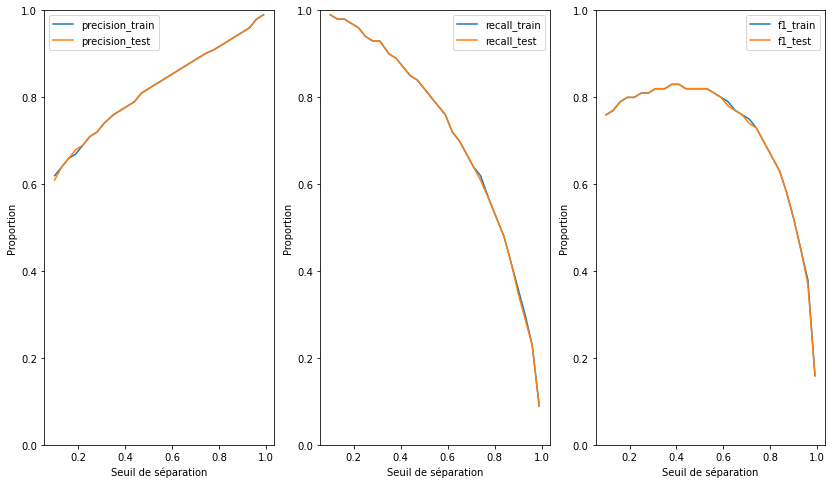

In [81]:
## Visualisation du recall, precision et f1 sur le train et le test

under_over_fitting([reg_log.predict_proba(x_train_mod),y_train],[reg_log.predict_proba(x_test_mod),y_test])

In [29]:
## Vérification de la stabilité et la robustesse du modèle

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

scores = cross_val_score(reg_log, x_test_mod, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

print(scores)

print(np.nanmean(scores))

[0.90016284 0.90059281 0.89778579 0.90172971 0.90174656 0.9001315
 0.90087572 0.89970033 0.90030356 0.90103753]
0.9004066358839085


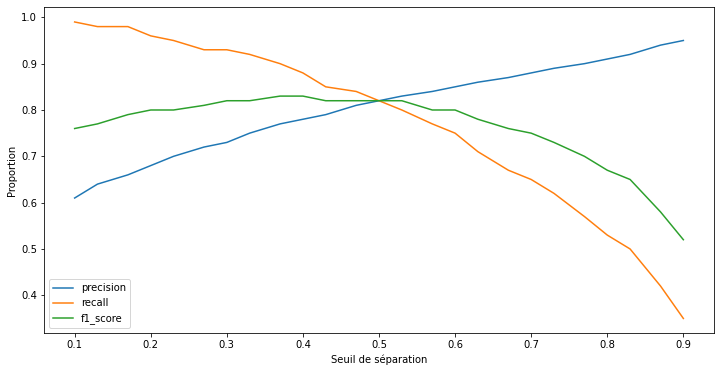

'La précision maximale est 0.95 pour le seuil de 0.9'

In [105]:
## Visualisation du recall, précision et f1score en fonction du seuil

trace_indicateur(reg_log.predict_proba(x_test_mod),y_test)

## Choix du meilleur seuil au regard du f1-score

In [141]:
### recherche du meilleur seuil au reagrd du f1-score

precisions, rappels, seuils = precision_recall_curve(y_val, reg_log.predict_proba(x_val_mod)[:,1])

precisions = precisions[:-1]

rappels = rappels[:-1]

condition = (rappels + precisions )> 0

precisions = precisions[condition]

rappels = rappels[condition]

seuils = seuils[condition]

f1_scores = 2 * rappels * precisions/(rappels + precisions)

val_seuil = seuils[np.argmax(f1_scores)]

print("Meilleur seuil : ", val_seuil)

Meilleur seuil :  0.9808312402097488


In [86]:
## Sortie des varaibles ainsi que les coefficients pour la regression logistique

intercept = pd.DataFrame({"Variables":["Intercept"],"Coefficients":[round(reg_log.intercept_[0],2)]})

df_coef_reglog = pd.DataFrame({"Variables":reg_log.feature_names_in_.tolist(),
              "Coefficients":list(map(lambda x: round(x[0],2), reg_log.coef_.T.tolist()))})

df_coef_reglog = pd.concat([intercept,df_coef_reglog], ignore_index=True)

df_coef_reglog.head()

Variables  Coefficients
0                  Intercept         -4.61
1           TOP_TOUT_HABITAT         -0.50
2  Devis_CAM_disc_Au_moins_1         -1.45
3         FORMULE_Prev_seule         -3.70
4         REGION_Rhône Alpes          0.77

<div class='alert alert-info'>
    <center> <h3> Mesure de la performance du modèle de Regression Logistique</h3> </center>
</div>

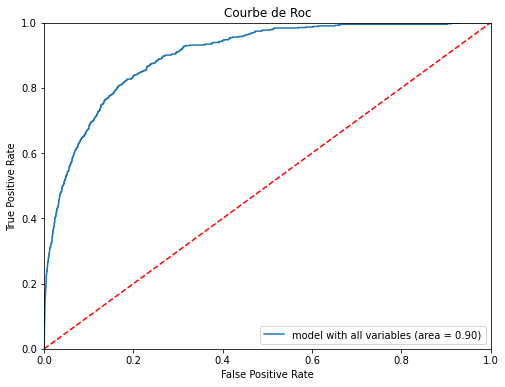

In [87]:
## Affichage de la courbe de ROC

roc_curve_model(reg_log, x_test_mod, y_test)

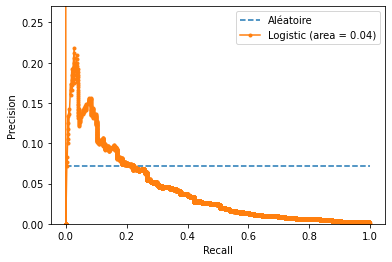

In [156]:
## visualition de la courbe precision recall et l'AUCPR

AUC_PR(reg_log, x_val_mod,y_val)

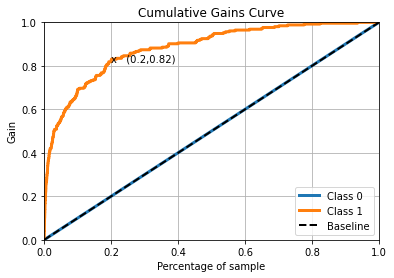

In [88]:
## Courbe de Gains cumulées

plt.rcParams["figure.figsize"]=[6,4]

skplt.metrics.plot_cumulative_gain(y_val, reg_log.predict_proba(x_val_mod))

pyplot.annotate('x   (0.2,0.82)', xy = (0.2, 0.82), xytext = (0.2, 0.82))
                                   
plt.show()

In [89]:
## courbe de Lift

def plot_lift_curve(y_val, y_pred, step=0.1):  
    """
    Cette fonction permet de calculer le Lift par décile si step=0.1, par centile si step=0.01, ...
    """
    aux_lift = pd.DataFrame()
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    x_val = np.arange(step,1+step,step)
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    y_v = []
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) 
        data_here = aux_lift.iloc[:num_data,:] 
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
    return x_val,y_v

def courbe_Lifts_cum(Lifts_cum,decile):
    """
    Cette fonction permettra l'affichage sous forme d'un diagramme en barre le Lift par décile ou centile, ainsi qu'une
    ligne rouge qui représente le gain lorsqu'on utilise un modèle aléatoire
    """
    
    fig = go.Figure()

    fig.add_trace(go.Bar(
        name = 'barplot',
        x = list(map(lambda x:str(round(x,2)),Lifts_cum)),
        y = decile, text=list(map(lambda x: f"{x:.2f}",decile)),textposition="outside",
        marker=dict(color=decile[::-1],colorscale='aggrnyl'),opacity=0.8
       ) )

    fig.add_trace(go.Scatter(
        name = 'line plot',
        x = list(map(lambda x:str(round(x,2)),Lifts_cum)),
        y = [1 for i in range(len(decile)+1)], line=dict(color='red', width=4, dash='dot')
       )
    )

    fig.update_yaxes(title="lift par décile")

    fig.update_xaxes(title="Proportion de l'échantillon",tickvals=list(range(len(decile))), ticktext=["10%","20%","30%","40%"
                                                                            ,"50%","60%","70%","80%","90%","100%"])



    fig.show()

In [90]:
### Appel des fonction précédentes pour afficher le lift par decile

lift, dec= plot_lift_curve(y_val,reg_log.predict_proba(x_val_mod)[:,1])

## Tracer de la courbe de Lift

courbe_Lifts_cum(lift, dec)

(0.0, 20.0)

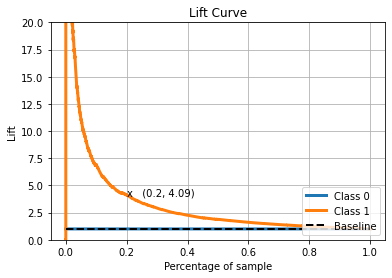

In [150]:
## Autre façon de représenter la courbe de Lift

skplt.metrics.plot_lift_curve(y_val, reg_log.predict_proba(x_val_mod))

pyplot.annotate('x   (0.2, 4.09)', xy = (0.2, 4.09), xytext = (0.2, 4.09))

plt.ylim(0,20)

In [33]:
## Observation concrete de la performance du modèle

x_val_mod.insert(0,"Score_RL",reg_log.predict_proba(x_val_mod)[:,1])

x_val_mod.insert(1,"TOP_RETRAITE", y_val)

x_val_mod.insert(0,"NOIDE",x_val["NOIDE"])

x_val_mod.sort_values("Score_RL", ascending=False, inplace=True)

x_val_mod.head()

NOIDE  Score_RL  TOP_RETRAITE  COUVRE_BE  REGION_Centre  \
45587   103798586  0.999933             0          0              0   
93684   104922286  0.999891             0          0              0   
141336  107090755  0.999835             0          0              0   
9232    107473307  0.999803             0          0              0   
121516  104135683  0.999740             0          0              0   

        COUVRE_BC  chgt_tr_cotis_n-2_n-1_0  TOP_PIM  \
45587           0                        1        0   
93684           0                        0        0   
141336          0                        1        0   
9232            0                        1        0   
121516          0                        1        0   

        Nbre_Equip_Hors_Retr_disc_Au_moins_1  chgt_tr_cotis_n-2_n-1_NC  \
45587                                      0                         0   
93684                                      1                         0   
141336                                     1                         0   
9232                                       1                         0   
121516                                     1                         0   

        nb_evolution_1_et_plus  Devis_CAM_disc_Au_moins_1  \
45587                        1                          0   
93684                        0                          0   
141336                       1                          0   
9232                         1                          0   
121516                       1                          0   

        Freq_moy_Camp/mois_disc_1_Camp/mois  REGION_Hauts De France  \
45587                                     1                       0   
93684                                     1                       0   
141336                                    0                       0   
9232                                      0                       1   
121516                                    1                       0   

        evol_cotis_n-1_n_baisse  NB_RECLA_disc_Au_moins_1  \
45587                         0                         0   
93684                         1                         1   
141336                        0                         0   
9232                          0                         0   
121516                        0                         1   

        evol_cotis_n-2_n-1_évolution  FORMULE_OJI  REGION_ILE DE France  \
45587                              1            0                     0   
93684                              0            0                     0   
141336                             1            0                     0   
9232                               0            0                     0   
121516                             1            0                     0   

        Freq_moy_email/mois_disc_1_mail/mois  Contact_Cour  \
45587                                      1             1   
93684                                      1             1   
141336                                     0             1   
9232                                       1             1   
121516                                     1             1   

        REGION_Rhône Alpes  Nbre_canaux_Devis_disc_Au_moins_1  \
45587                    0                                  1   
93684                    0                                  1   
141336                   0                                  1   
9232                     0                                  1   
121516                   1                                  1   

        NAT_ACTIVITE_Retraité  REGION_Pays de la Loire   evol_cotis_n-1_n_NC  \
45587                       0                         0                    0   
93684                       0                         0                    0   
141336                      0                         0                    0   
9232                        0                         0                    0   
121516                      0    

In [34]:
## On regarde le nombre de souscription dans le jeu de validation lorsqu'on n'utilise pas le modèle

x_val_mod["TOP_RETRAITE"].value_counts()

0    182433
1       254
Name: TOP_RETRAITE, dtype: int64

In [36]:
## On récupère les 20% les mieux scorés

n_mieux_score = int(np.ceil(0.2*len(x_val_mod)))

n_mieux_score

36538

In [38]:
## On regarde le nombre de souscriptions parmi ces 20%

x_val_mod.iloc[:n_mieux_score,2].sum()

208

In [41]:
## le gain cumulé sur 20% est donc de 

np.round(208/254,2)

0.82

In [43]:
## Le lift est de

round((208/n_mieux_score)/(254/x_val_mod.shape[0]),2)

## ce modèle fait donc 4 fois mieux que l'aléatoire sur les 20% les mieux scorés

4.09

## Test sur le deployement en 2023

In [93]:
df_val_2022_mod = df_val_2022.drop(["NOIDE","TOP_RETRAITE","Devis_Epargne_retraite_disc_Au_moins_1"], axis=1).copy()

In [97]:
### Appel des fonctions précédentes pour afficher le lift par decile

lift_val, dec_val= plot_lift_curve(df_val_2022["TOP_RETRAITE"].astype(int),reg_log.predict_proba(df_val_2022_mod)[:,1])

## Tracer de la courbe de Lift

courbe_Lifts_cum(lift_val, dec_val)

In [98]:
## Observation concrete de la performance du modèle si il était utilisé pour la campagne en 2023

df_val_2022_mod.insert(0,"Score_RL",reg_log.predict_proba(df_val_2022_mod)[:,1])

df_val_2022_mod.insert(1,"TOP_RETRAITE", df_val_2022["TOP_RETRAITE"].astype(int))

df_val_2022_mod.insert(0,"NOIDE",df_val_2022["NOIDE"])

df_val_2022_mod.sort_values("Score_RL", ascending=False, inplace=True)

df_val_2022_mod.head()

NOIDE  Score_RL  TOP_RETRAITE  TOP_TOUT_HABITAT  \
507500  0105497751  0.999985             0                 0   
1129    0108721162  0.999961             0                 0   
487091  0103798586  0.999959             0                 0   
964     0100122449  0.999943             1                 0   
2281    0107501394  0.999903             0                 0   

        Devis_CAM_disc_Au_moins_1  FORMULE_Prev_seule  REGION_Rhône Alpes  \
507500                          0                   0                   0   
1129                            0                   0                   0   
487091                          0                   0                   0   
964                             0                   0                   0   
2281                            0                   0                   0   

        COUVRE_BC  Freq_moy_Camp/mois_disc_1_Camp/mois  \
507500          0                                    0   
1129            0                                    1   
487091          0                                    1   
964             0                                    1   
2281            0                                    1   

        evol_cotis_n-1_n_stable  Devis_Assur_Vie_disc_Au_moins_1  \
507500                        0                                0   
1129                          0                                1   
487091                        0                                1   
964                           0                                1   
2281                          0                                1   

        chgt_tr_cotis_n-1_n_1  FORMULE_Reference  \
507500                      0                  0   
1129                        0                  0   
487091                      0                  0   
964                         0                  1   
2281                        0                  1   

        Nbre_Camp_Conq_disc_Au_moins_1  PROPO_INTERNET_disc_Au_moins_1  \
507500                               0                               1   
1129                                 0                               1   
487091                               0                               1   
964                                  0                               1   
2281                                 0                               1   

        evol_cotis_n-2_n-1_stable  TYPE_COTISATION_Taux  \
507500                          0                     1   
1129                            0                     1   
487091                          0                     1   
964                             0                     1   
2281                            0                     1   

        Freq_moy_email/mois_disc_1_mail/mois  TOP_HABITAT_MGEN  \
507500                                     0                 0   
1129                                       1                 0   
487091                                     1                 0   
964                                        1                 0   
2281                                       1                 0   

        Freq_moy_TEL/mois_disc_Aucun_TEL/mois  \
507500                                      1   
1129                                        0   
487091                                      1   
964                                         0   
2281                                        0   

        Freq_moy_email/mois_disc_ciblé_1_fois  TOP_ASSUR_VIE  \
507500                                      1              0   
1129                                        0              1   
487091                                      0              0   
964                                         0              1   
2281                                        0              1   

        REGION_ILE DE France  REGION_Aquitaine  REGION_Pays de la Loire   \
507500                     0                 0                         0   
1129                       0                 1                   

In [99]:
## Taille du fichier

df_val_2022_mod.shape

(598910, 134)

In [101]:
## Nombre de souscripteur retraite enregistré en aout 2023

df_val_2022_mod["TOP_RETRAITE"].value_counts()

0    597874
1      1036
Name: TOP_RETRAITE, dtype: int64

In [105]:
## On récupère les 10% les mieux scorés

n_mieux_score = int(np.ceil(0.1*len(df_val_2022_mod)))

n_mieux_score

59891

In [106]:
## On regarde le nombre de souscriptions parmi ces 10%

df_val_2022_mod.iloc[:n_mieux_score,2].sum()

659

In [107]:
## le gain cumulé sur 10% est donc de 64%

np.round(659/1036,2)

0.64

In [108]:
## Le lift est de

round((659/n_mieux_score)/(1036/df_val_2022_mod.shape[0]),2)

## ce modèle fait donc 6 fois mieux que l'aléatoire sur les 10% les mieux scorés

6.36

## Random Forest

In [112]:
x_val_mod = x_val.drop("NOIDE", axis=1)

RF_model= RandomForestClassifier(n_estimators=120,random_state=42,criterion="entropy",
                                 max_depth=10, max_features=40, max_leaf_nodes=90,min_samples_leaf=90,n_jobs=-1) 

RF_model.fit(x_train_mod, y_train)

y_pred = RF_model.predict(x_test_mod)

print(roc_auc_score(y_test,RF_model.predict_proba(x_test_mod)[:,1]))

print(average_precision_score(y_val,RF_model.predict_proba(x_val_mod)[:,1]))
                       
print(classification_report(y_test,y_pred)) 

0.9400537968018008
0.03869111052904746
              precision    recall  f1-score   support

           0       0.84      0.87      0.85    127767
           1       0.87      0.83      0.85    127634

    accuracy                           0.85    255401
   macro avg       0.85      0.85      0.85    255401
weighted avg       0.85      0.85      0.85    255401



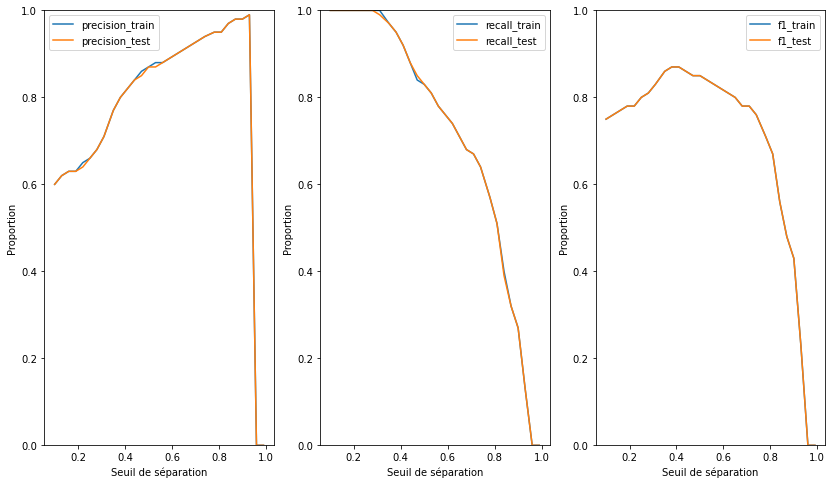

In [113]:
 ## Visualisation du recall, precision et f1 sur le train et le test
    
#warnings.filterwarnings('ignore')

under_over_fitting([RF_model.predict_proba(x_train_mod),y_train],[RF_model.predict_proba(x_test_mod),y_test])

In [47]:
## Vérification de la stabilité et la robustesse du modèle

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

scores = cross_val_score(RF_model, x_test_mod, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)

print(scores)

print(np.nanmean(scores))

[0.93827174 0.93871254 0.93719901 0.93873293 0.93954209 0.93707818
 0.93944539 0.93775437 0.93902904 0.9394543 ]
0.9385219590831451


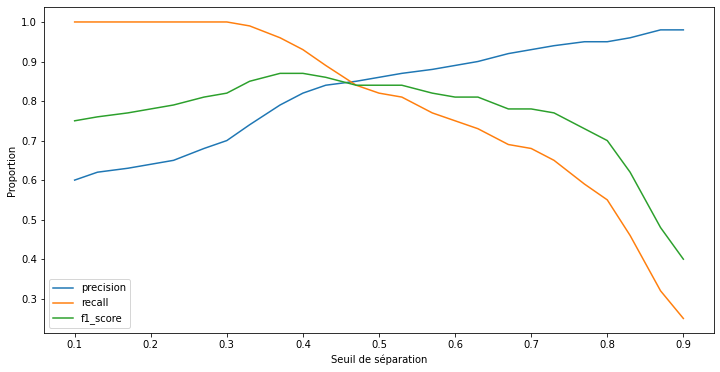

'La précision maximale est 0.98 pour le seuil de 0.87'

In [48]:
## Visualisation du recall, précision et f1score en fonction du seuil

trace_indicateur(RF_model.predict_proba(x_test_mod),y_test)

In [142]:
## Choix du meilleur seuil au regard du f1-score 

precisions, rappels, seuils = precision_recall_curve(y_val, RF_model.predict_proba(x_val_mod)[:,1])

precisions = precisions[:-1]
rappels = rappels[:-1]
condition = (rappels + precisions )> 0
precisions = precisions[condition]
rappels = rappels[condition]
seuils = seuils[condition]

f1_scores = 2 * rappels * precisions/(rappels + precisions)

val_seuil = seuils[np.argmax(f1_scores)]

print("Meilleur seuil : ", val_seuil)

Meilleur seuil :  0.9272500566212435


In [143]:
## rapport de classification et matrice de confusion

y_pred = (RF_model.predict_proba(x_test_mod)[:,1]>0.87).astype(int)

print(classification_report(y_test,y_pred))

confu = pd.DataFrame(list(zip(y_test["TOP_RETRAITE"],y_pred)), columns=["Test","Pred"])

print("Matrice de Confusion")

pd.crosstab(confu["Test"].astype(str),confu["Pred"].astype(str), margins=True, margins_name="Global")

              precision    recall  f1-score   support

           0       0.59      0.99      0.74    127767
           1       0.98      0.32      0.48    127634

    accuracy                           0.66    255401
   macro avg       0.79      0.66      0.61    255401
weighted avg       0.79      0.66      0.61    255401

Matrice de Confusion


Pred         0      1  Global
Test                         
0       126929    838  127767
1        86567  41067  127634
Global  213496  41905  255401

<div class='alert alert-info'>
    <center> <h3> Mesure de la performance du modèle de Random forest</h3> </center>
</div>

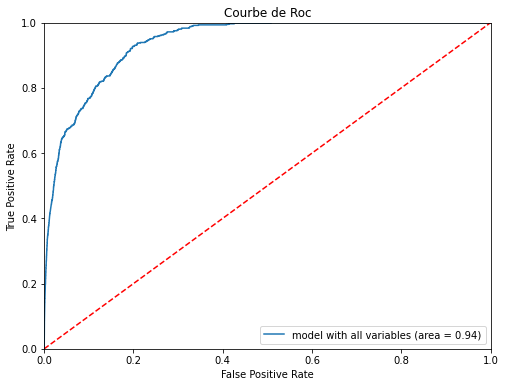

In [60]:
## Affichage de la courbe de ROC

roc_curve_model(RF_model, x_test_mod, y_test)

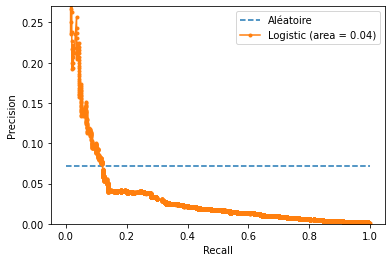

In [157]:
## visualition de la courbe precision recall et l'AUCPR

AUC_PR(RF_model, x_val_mod,y_val)

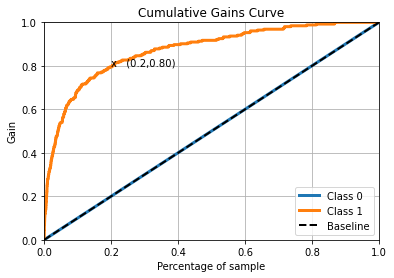

In [65]:
## Courbe de Gains cumulés

plt.rcParams["figure.figsize"]=[6,4]

skplt.metrics.plot_cumulative_gain(y_val, RF_model.predict_proba(x_val_mod))

pyplot.annotate('x   (0.2,0.80)', xy = (0.2, 0.80), xytext = (0.2, 0.80))
                                   
plt.show()

In [63]:
### Appel des fonction précédentes pour afficher le lift par decile

lift, dec= plot_lift_curve(y_val,RF_model.predict_proba(x_val_mod)[:,1])

## Tracer de la courbe de Lift

courbe_Lifts_cum(lift, dec)

(0.0, 20.0)

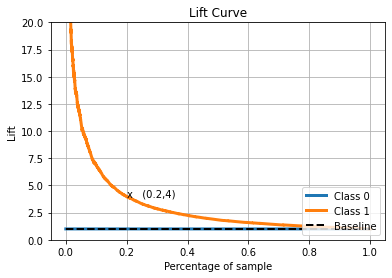

In [151]:
## Autre façon de représenter la courbe de Lift

skplt.metrics.plot_lift_curve(y_val, RF_model.predict_proba(x_val_mod))

pyplot.annotate('x   (0.2,4)', xy = (0.2, 4), xytext = (0.2, 4))

plt.ylim(0,20)

<div class='alert alert-info'>
    <center> <h3> Interprétation du modèle de Random forest</h3> </center>
</div>

Pour interpreter le random forest, je vais sélectionner les variables les plus importantes du modèle, relancer le modèle avec uniquement ces variables et enfin faire une interpretaion des valeurs de shapleys.\
Je fais cela parce que avec plus 130 variables, le calcul des chapleys pour chaque observation sera très long, et faire ainsi minimise le temps de calcul mais n'altère pour autant pas l'interpretation que je ferais, même si les valeurs de shapely pourrons être un peu pessimiste mais le signe est le même.

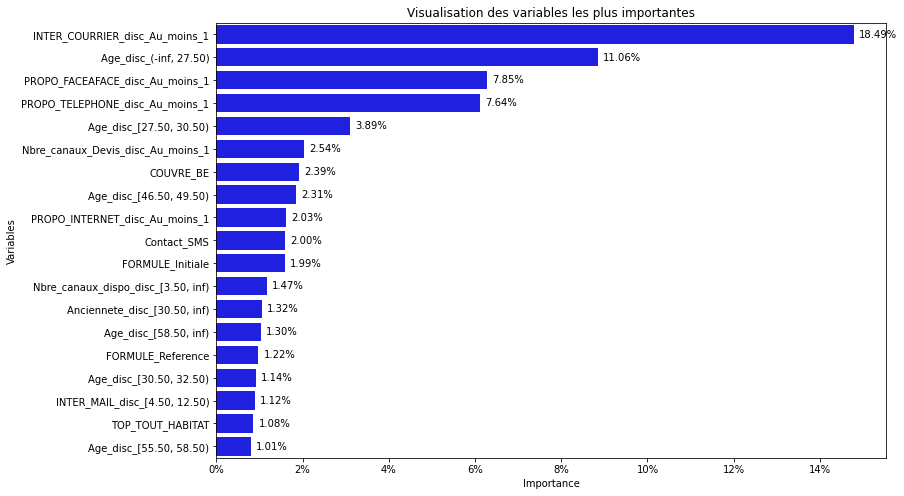

In [122]:
## datarame contenant l'importance des variables

feature = pd.DataFrame(100*RF_model.feature_importances_, 
                       index=x_train_mod.columns, columns=["Importance"]).sort_values("Importance", ascending=False).reset_index()

plt.figure(figsize=(12,8))

ax = sns.barplot(data=feature[feature["Importance"]>1], y="index",x="Importance", orient="h", color="blue")

for p in ax.patches:
    ax.annotate(f"{p.get_width():.2f}%", xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
    
ax.xaxis.set_ticklabels(map(lambda x: str(x)+"%", range(0,20,2)))

plt.ylabel("Variables")

plt.title("Visualisation des variables les plus importantes")

plt.show()

In [76]:
## variables dont l'importance est > 0.5%

liste_imp_RF = list(feature.loc[feature["Importance"]>0.5,"index"])

liste_imp_RF

['INTER_COURRIER_disc_Au_moins_1',
 'Age_disc_(-inf, 27.50)',
 'PROPO_FACEAFACE_disc_Au_moins_1',
 'PROPO_TELEPHONE_disc_Au_moins_1',
 'Age_disc_[27.50, 30.50)',
 'Nbre_canaux_Devis_disc_Au_moins_1',
 'FORMULE_Initiale',
 'COUVRE_BE',
 'PROPO_INTERNET_disc_Au_moins_1',
 'Age_disc_[46.50, 49.50)',
 'Contact_SMS',
 'Age_disc_[58.50, inf)',
 'Nbre_canaux_dispo_disc_[3.50, inf)',
 'FORMULE_Reference',
 'Age_disc_[30.50, 32.50)',
 'Age_disc_[55.50, 58.50)',
 'TOP_TOUT_HABITAT',
 'Anciennete_disc_[30.50, inf)',
 'INTER_MAIL_disc_[4.50, 12.50)',
 'Age_disc_[49.50, 55.50)',
 'Devis_Assur_Obs_disc_Au_moins_1',
 'REGION_Rhône Alpes',
 'REGION_ILE DE France',
 'Nbre_Equip_Hors_Retr_disc_Au_moins_1',
 'TYPE_COTISATION_Forfait',
 'Age_disc_[32.50, 35.50)',
 'TYPE_COTISATION_Taux',
 'TOP_DECES',
 'REGION_PACA Corse',
 'Devis_Assur_Décès_disc_Au_moins_1',
 'Nbre_Camp_Multiequip_disc_[0.50, 2.50)',
 'TOP_HABITAT_MGEN',
 'INTER_MAIL_disc_(-inf, 4.50)',
 'NB_RECLA_disc_Au_moins_1',
 'MTT_COT_AN_disc_[16

In [103]:
# Lancement du modèle basé uniquement sur les variables importantes

RF_model_imp= RandomForestClassifier(n_estimators=170,max_depth=15, max_features=10, max_leaf_nodes=100,min_samples_leaf=90 
                                 ,random_state=42,criterion="entropy", n_jobs=-1)

RF_model_imp.fit(x_train_mod[liste_imp_RF], y_train)

y_pred = RF_model_imp.predict(x_test_mod[liste_imp_RF])

print(roc_auc_score(y_test,RF_model_imp.predict_proba(x_test_mod[liste_imp_RF])[:,1]))

print(average_precision_score(y_val,RF_model_imp.predict_proba(x_val_mod[liste_imp_RF])[:,1]))
                       
print(classification_report(y_test,y_pred)) 

0.9251437026099756
0.032726871357848936
              precision    recall  f1-score   support

           0       0.84      0.84      0.84    127767
           1       0.84      0.84      0.84    127634

    accuracy                           0.84    255401
   macro avg       0.84      0.84      0.84    255401
weighted avg       0.84      0.84      0.84    255401



In [109]:
## Interpretaion du modèle par les valeurs de shapleys

explainer_RF = shap.Explainer(RF_model_imp)

shap_values_RF = explainer_RF(x_val_mod[liste_imp_RF])

In [87]:
## Calcul de la moyenne des préditions pour comparer avec la moyenne des preditions calculée par shap

y_pred = RF_model_imp.predict_proba(x_train_mod[liste_imp_RF])

y_pred.mean(axis=0)

array([0.49984157, 0.50015843])

In [117]:
## moyenne des preditions calculée par shap, C'est quasi les mêmes avec ce qui a été calculé précédemment

shap_values_RF.base_values[0]

array([0.4998902, 0.5001098])

In [122]:
## Observation concrete de la performance du modèle

x_val_mod.insert(0,"Score_RF",RF_model_imp.predict_proba(x_val_mod[liste_imp_RF])[:,1])

x_val_mod.insert(1,"TOP_RETRAITE", y_val)

x_val_mod.insert(0,"NOIDE",x_val["NOIDE"])

x_val_mod.sort_values("Score_RF", ascending=False, inplace=True)

x_val_mod.head()

NOIDE  Score_RF  TOP_RETRAITE  COUVRE_BE  REGION_Centre  \
45587   103798586  0.959963             0          0              0   
119031  105689356  0.957337             1          0              0   
136195  105466592  0.956661             1          0              0   
88676   103785650  0.956339             0          0              0   
129777  108166077  0.955823             0          0              0   

        COUVRE_BC  chgt_tr_cotis_n-2_n-1_0  TOP_PIM  \
45587           0                        1        0   
119031          0                        0        0   
136195          0                        0        0   
88676           0                        1        0   
129777          0                        0        1   

        Nbre_Equip_Hors_Retr_disc_Au_moins_1  chgt_tr_cotis_n-2_n-1_NC  \
45587                                      0                         0   
119031                                     1                         1   
136195                                     1                         1   
88676                                      0                         0   
129777                                     1                         1   

        nb_evolution_1_et_plus  Devis_CAM_disc_Au_moins_1  \
45587                        1                          0   
119031                       0                          0   
136195                       0                          0   
88676                        1                          0   
129777                       0                          0   

        Freq_moy_Camp/mois_disc_1_Camp/mois  REGION_Hauts De France  \
45587                                     1                       0   
119031                                    1                       0   
136195                                    1                       0   
88676                                     1                       0   
129777                                    1                       0   

        evol_cotis_n-1_n_baisse  NB_RECLA_disc_Au_moins_1  \
45587                         0                         0   
119031                        0                         0   
136195                        0                         0   
88676                         0                         0   
129777                        0                         0   

        evol_cotis_n-2_n-1_évolution  FORMULE_OJI  REGION_ILE DE France  \
45587                              1            0                     0   
119031                             0            0                     0   
136195                             0            0                     0   
88676                              1            0                     0   
129777                             0            0                     0   

        Freq_moy_email/mois_disc_1_mail/mois  Contact_Cour  \
45587                                      1             1   
119031                                     1             1   
136195                                     0             1   
88676                                      1             1   
129777                                     1             1   

        REGION_Rhône Alpes  Nbre_canaux_Devis_disc_Au_moins_1  \
45587                    0                                  1   
119031                   0                                  1   
136195                   0                                  1   
88676                    1                                  1   
129777                   0                                  1   

        NAT_ACTIVITE_Retraité  REGION_Pays de la Loire   evol_cotis_n-1_n_NC  \
45587                       0                         0                    0   
119031                      0                         1                    1   
136195                      0                         0                    1   
88676                       0                         0                    0   
129777                      0    

### Valeurs Shapleys du plus scoré

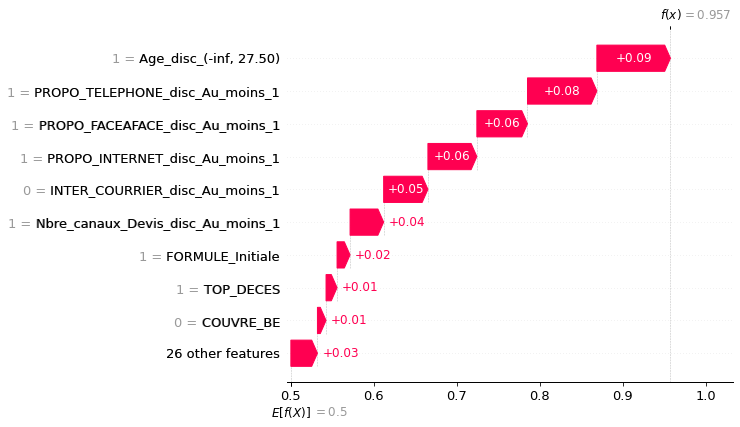

In [126]:
## Visualisation de l'explication du plus scoré ayant souscrit

exp_score = shap.Explanation(shap_values_RF[119031].values[:,1],shap_values_RF[119031].base_values[1],
                       shap_values_RF[119031].data,feature_names=liste_imp_RF)

shap.plots.waterfall(exp_score, max_display=10)

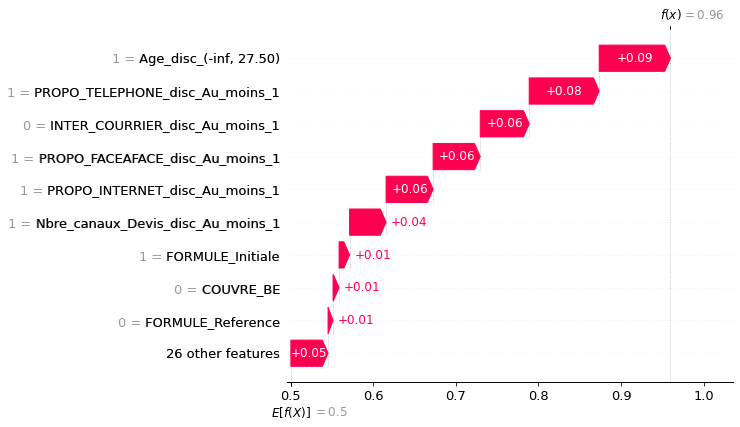

In [127]:
## Visualisation de l'explication du plus scoré n'ayant pas souscrit

exp_score = shap.Explanation(shap_values_RF[45587].values[:,1],shap_values_RF[45587].base_values[1],
                       shap_values_RF[45587].data,feature_names=liste_imp_RF)

shap.plots.waterfall(exp_score, max_display=10)

In [128]:
## Visualisation de l'explication du plus scoré n'ayant pas souscrit
## Les conclusions sont identiques à la représentation précédente

shap.initjs()

shap.plots.force(exp_score)

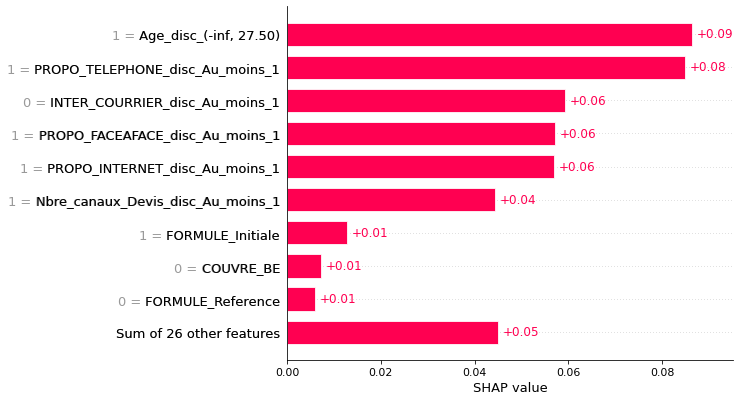

In [129]:
## Une autre façon de représenter, toujours les mêmes conclusions

shap.plots.bar(exp_score)

### valeurs shapelys du moins scoré

In [130]:
x_val_mod.tail()

NOIDE  Score_RF  TOP_RETRAITE  COUVRE_BE  REGION_Centre  \
177075  100731664  0.001535             0          0              1   
10712   102857825  0.001535             0          0              0   
49801   100620373  0.001535             0          0              0   
74286   101362147  0.001535             0          0              0   
46502   102893246  0.001535             0          0              0   

        COUVRE_BC  chgt_tr_cotis_n-2_n-1_0  TOP_PIM  \
177075          0                        0        0   
10712           0                        0        0   
49801           0                        1        0   
74286           0                        1        0   
46502           0                        1        0   

        Nbre_Equip_Hors_Retr_disc_Au_moins_1  chgt_tr_cotis_n-2_n-1_NC  \
177075                                     0                         0   
10712                                      0                         0   
49801                                      0                         0   
74286                                      0                         0   
46502                                      0                         0   

        nb_evolution_1_et_plus  Devis_CAM_disc_Au_moins_1  \
177075                       1                          0   
10712                        1                          0   
49801                        1                          0   
74286                        0                          0   
46502                        1                          0   

        Freq_moy_Camp/mois_disc_1_Camp/mois  REGION_Hauts De France  \
177075                                    1                       0   
10712                                     1                       0   
49801                                     1                       0   
74286                                     1                       0   
46502                                     1                       0   

        evol_cotis_n-1_n_baisse  NB_RECLA_disc_Au_moins_1  \
177075                        0                         0   
10712                         0                         0   
49801                         0                         0   
74286                         0                         0   
46502                         0                         0   

        evol_cotis_n-2_n-1_évolution  FORMULE_OJI  REGION_ILE DE France  \
177075                             1            0                     0   
10712                              1            0                     0   
49801                              1            0                     0   
74286                              0            0                     0   
46502                              1            0                     0   

        Freq_moy_email/mois_disc_1_mail/mois  Contact_Cour  \
177075                                     1             1   
10712                                      0             1   
49801                                      1             1   
74286                                      1             1   
46502                                      0             1   

        REGION_Rhône Alpes  Nbre_canaux_Devis_disc_Au_moins_1  \
177075                   0                                  0   
10712                    0                                  0   
49801                    0                                  0   
74286                    0                                  0   
46502                    0                                  0   

        NAT_ACTIVITE_Retraité  REGION_Pays de la Loire   evol_cotis_n-1_n_NC  \
177075                      0                         0                    0   
10712                       0                         0                    0   
49801                       0                         0                    0   
74286                       0                         0                    0   
46502                       0    

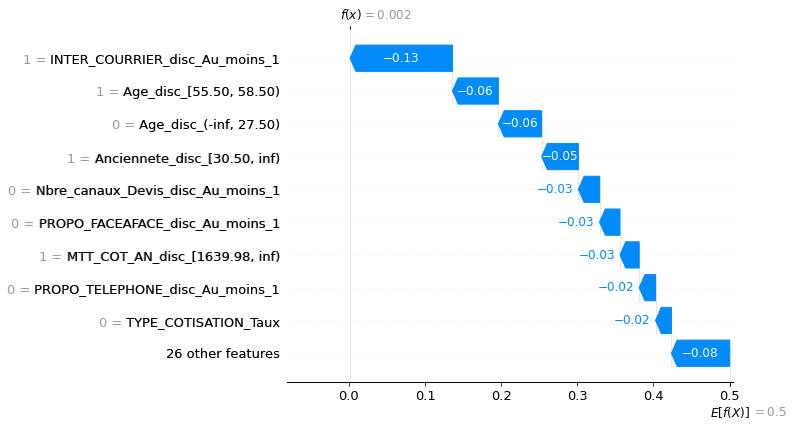

In [131]:
## Visualisation de l'explication du moins scoré

exp_score = shap.Explanation(shap_values_RF[46502].values[:,1],shap_values_RF[46502].base_values[1],
                       shap_values_RF[46502].data,feature_names=liste_imp_RF)

shap.plots.waterfall(exp_score, max_display=10)

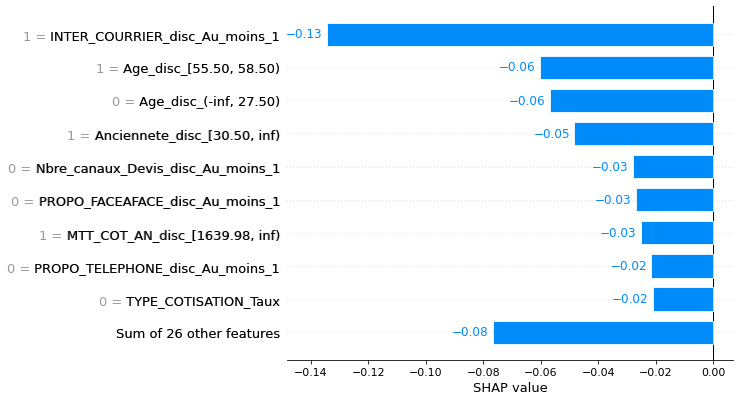

In [132]:
## Une autre façon de représenter, toujours les mêmes conclusions

shap.plots.bar(exp_score)

### Shapley Global

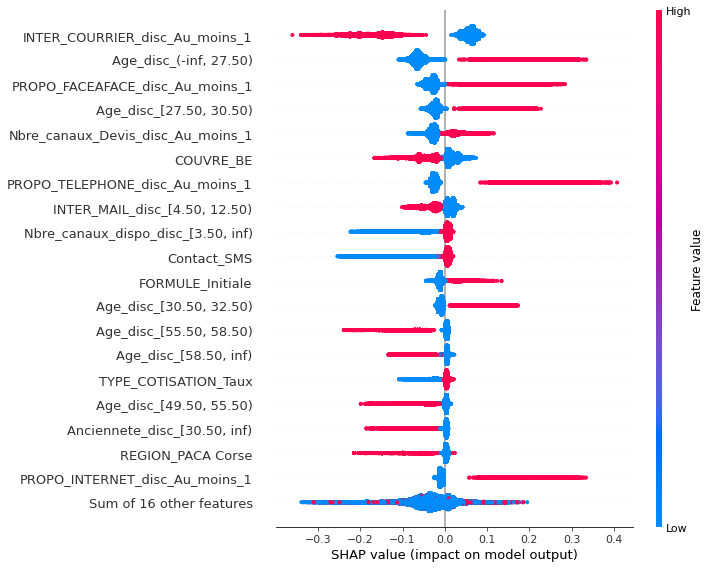

In [134]:
exp_global = shap.Explanation(shap_values_RF.values[:,:,1],shap_values_RF.base_values[:,1],
                       shap_values_RF.data,feature_names=liste_imp_RF)

shap.plots.beeswarm(exp_global, max_display=20)

<div class='alert alert-info'>
    <center> <h3> Modèle réseau de neuronne </h3> </center>
</div>

In [172]:
## Normalisation

scale = StandardScaler().fit(x_train_mod)

x_train_scale = scale.transform(x_train_mod)

x_test_scale = scale.transform(x_test_mod)

x_val_mod_scale = scale.transform(x_val_mod)

In [209]:
# one hot encode outputs


y_train_keras = to_categorical(y_train.astype(int))

y_test_keras = to_categorical(y_test.astype(int))

y_val_keras = to_categorical(y_val.astype(int))

count_classes = y_test_keras.shape[1]

print(count_classes)

model = Sequential()

model.add(Dense(150, activation='relu', input_dim=131, name="Couche_entree"))

model.add(Dense(100, activation='relu', name="1er_Couche_cachee"))

model.add(Dense(50, activation='relu', name="2ieme_Couche_cachee"))

model.add(Dense(200, activation='relu', name="Couche_cachee"))

model.add(Dropout(0.7))

model.add(Dense(2, activation='softmax', name="Couche_sortie"))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# build the model
history = model.fit(x_train_scale, y_train_keras, epochs=10, batch_size=10000, 
                    validation_data=[x_test_scale,y_test_keras], verbose=1)

2
Epoch 1/10
60/60 [==============================] - 3s 46ms/step - loss: 9.0415 - accuracy: 0.6568 - val_loss: 0.5264 - val_accuracy: 0.7555
Epoch 2/10
60/60 [==============================] - 3s 42ms/step - loss: 0.5758 - accuracy: 0.7465 - val_loss: 0.5468 - val_accuracy: 0.7707
Epoch 3/10
60/60 [==============================] - 2s 41ms/step - loss: 0.5596 - accuracy: 0.7572 - val_loss: 0.5262 - val_accuracy: 0.7750
Epoch 4/10
60/60 [==============================] - 3s 42ms/step - loss: 0.5324 - accuracy: 0.7664 - val_loss: 0.4836 - val_accuracy: 0.7771
Epoch 5/10
60/60 [==============================] - 3s 42ms/step - loss: 0.5043 - accuracy: 0.7662 - val_loss: 0.4778 - val_accuracy: 0.7805
Epoch 6/10
60/60 [==============================] - 3s 42ms/step - loss: 0.4934 - accuracy: 0.7664 - val_loss: 0.4769 - val_accuracy: 0.7848
Epoch 7/10
60/60 [==============================] - 3s 43ms/step - loss: 0.5208 - accuracy: 0.7722 - val_loss: 0.5377 - val_accuracy: 0.7679
Epoch 8/10


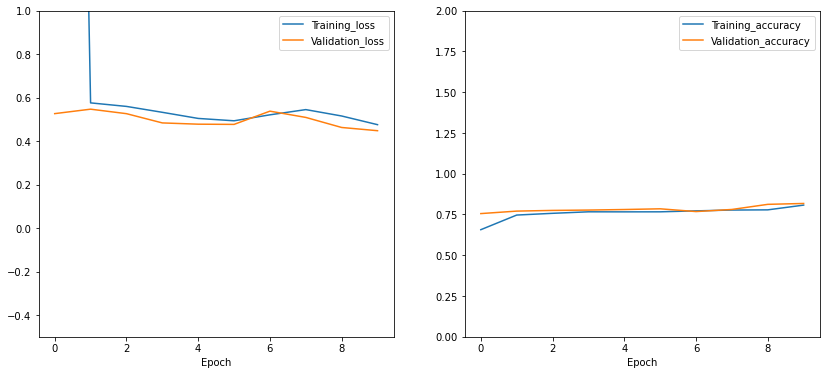

In [210]:

#plt.figure(figsize=(12,5))

plt.rcParams['figure.figsize'] = [14, 6]

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(history.history["loss"],label="Training_loss")

ax1.plot(history.history["val_loss"],label="Validation_loss")

ax1.legend()

ax1.set_xlabel("Epoch")

ax1.set_ylim(-0.5,1)

ax2.plot(history.history["accuracy"],label="Training_accuracy")

ax2.plot(history.history["val_accuracy"],label="Validation_accuracy")

ax2.set_xlabel("Epoch")

ax2.set_ylim(0,2)

ax2.legend()

plt.show()

5709/5709 [==============================] - 5s 794us/step


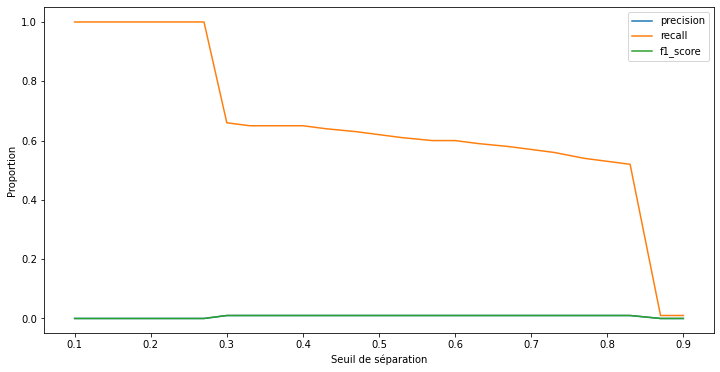

'La précision maximale est 0.01 pour le seuil de 0.3'

In [211]:
pred_train = history.model.predict(x_val_mod_scale)

trace_indicateur(pred_train, y_val)

In [212]:
y_pred = (pred_train[:,1]>=0.6).astype(int)

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    182433
           1       0.01      0.60      0.01       254

    accuracy                           0.87    182687
   macro avg       0.50      0.73      0.47    182687
weighted avg       1.00      0.87      0.93    182687



In [213]:
## AUCPR

average_precision_score(y_val,pred_train[:,1])

0.005226042750726075

In [214]:
## Courbe de Lift pour le modèle de réseau de neuronne

lift_rn, dec_rn= plot_lift_curve(y_val,pred_train[:,1])

## Tracer de la courbe de Lift

courbe_Lifts_cum(lift_rn, dec_rn)

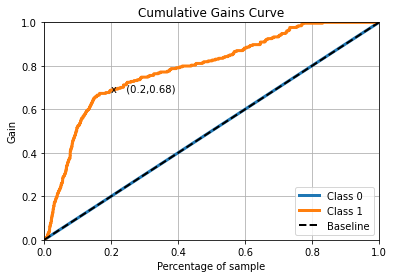

In [220]:
## Courbe de Gains cumulés

plt.rcParams["figure.figsize"]=[6,4]

skplt.metrics.plot_cumulative_gain(y_val, pred_train)

pyplot.annotate('x   (0.2,0.68)', xy = (0.2, 0.68), xytext = (0.2, 0.68))
                                   
plt.show()

<div class='alert alert-info'>
    <center> <h3> Extraction des Noides pour le ciblage marketing </h3> </center>
</div>

In [161]:
def extraction_camp_market(model, X, X_noide, decile):
    """
    Cette fonction va renvoyer une liste de NOIDE les mieux scorés correspondant à un decile de la base entrée en paramètre
    X est la base qui sera utilisé pour faire la prediction et X_noide est la même base que X mais contient en 
    plus la colonne NOIDE
    """
    X = X_noide.drop(["NOIDE","TOP_RETRAITE","Devis_Epargne_retraite_disc_Au_moins_1"], axis=1)
    
    X.insert(0,"Score",model.predict_proba(X)[:,1])

    X.insert(0,"NOIDE",X_noide["NOIDE"])

    X.sort_values("Score", ascending=False, inplace=True)

    n_noide = int(np.ceil(decile*X.shape[0]))
    
    ## Export des noides les plus scorés

    pd.DataFrame(list(X.iloc[:n_noide,0]), columns=["NOIDE"]).to_csv(r"P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\NOIDE_Plus_Score\Les_" + str(int(decile*100))+"%_Noide_plus_score_du_"+datetime.now().date().strftime('%Y_%m_%d')+'.csv', index=False,sep='|', encoding='mbcs')
    
    return X

In [162]:
## Appel de la fonction pour obtenir les noides les mieux scorés

validation_score = extraction_camp_market(reg_log, df_val_2022_mod,df_val_2022, 0.1)

validation_score.head()

NOIDE     Score  TOP_TOUT_HABITAT  Devis_CAM_disc_Au_moins_1  \
507500  0105497751  0.999985                 0                          0   
1129    0108721162  0.999961                 0                          0   
487091  0103798586  0.999959                 0                          0   
964     0100122449  0.999943                 0                          0   
2281    0107501394  0.999903                 0                          0   

        FORMULE_Prev_seule  REGION_Rhône Alpes  COUVRE_BC  \
507500                   0                   0          0   
1129                     0                   0          0   
487091                   0                   0          0   
964                      0                   0          0   
2281                     0                   0          0   

        Freq_moy_Camp/mois_disc_1_Camp/mois  evol_cotis_n-1_n_stable  \
507500                                    0                        0   
1129                                      1                        0   
487091                                    1                        0   
964                                       1                        0   
2281                                      1                        0   

        Devis_Assur_Vie_disc_Au_moins_1  chgt_tr_cotis_n-1_n_1  \
507500                                0                      0   
1129                                  1                      0   
487091                                1                      0   
964                                   1                      0   
2281                                  1                      0   

        FORMULE_Reference  Nbre_Camp_Conq_disc_Au_moins_1  \
507500                  0                               0   
1129                    0                               0   
487091                  0                               0   
964                     1                               0   
2281                    1                               0   

        PROPO_INTERNET_disc_Au_moins_1  evol_cotis_n-2_n-1_stable  \
507500                               1                          0   
1129                                 1                          0   
487091                               1                          0   
964                                  1                          0   
2281                                 1                          0   

        TYPE_COTISATION_Taux  Freq_moy_email/mois_disc_1_mail/mois  \
507500                     1                                     0   
1129                       1                                     1   
487091                     1                                     1   
964                        1                                     1   
2281                       1                                     1   

        TOP_HABITAT_MGEN  Freq_moy_TEL/mois_disc_Aucun_TEL/mois  \
507500                 0                                      1   
1129                   0                                      0   
487091                 0                                      1   
964                    0                                      0   
2281                   0                                      0   

        Freq_moy_email/mois_disc_ciblé_1_fois  TOP_ASSUR_VIE  \
507500                                      1              0   
1129                                        0              1   
487091                                      0              0   
964                                         0              1   
2281                                        0              1   

        REGION_ILE DE France  REGION_Aquitaine  REGION_Pays de la Loire   \
507500                     0                 0                         0   
1129                       0                 1                         0   
487091                     0                 0                         0   
964                        0                 0            

<div class='alert alert-danger'>
    <center> <h3> Fin du score </h3> </center>
</div>

<div class='alert alert-info'>
    <center> <h3> Pour plus améliorer le modele de random forest </h3> </center>
</div>

In [ ]:
## On peut aussi l'utliser pour un modèle linéaire

Random_forest = RandomForestClassifier()

parametre = {'n_estimators' : [100, 200,300],
            'max_features' : [10,20,30],
             "min_samples_leaf" : [10,15,20],
             "max_depth" : [10,15,20],
             "criterion": ["gini","entropy","log_loss"],
            "class_weight":["balanced","balanced_subsample"],
             "max_samples":[.7,.8,1]
            }

optimal_params =GridSearchCV(
        Random_forest, 
        parametre,
        cv=5,
        verbose=0
    ,scoring='roc_auc'
    )

optimal_params.fit(x_train,y_train)

print(optimal_params.best_params_)

## Sous echantillonage aléatoire

In [5]:
X_train_disc = df_etude_undersample.drop(["TOP_RETRAITE","Devis_Epargne_retraite_disc_Au_moins_1"], axis=1).copy()

Y_train_disc = df_etude_undersample["TOP_RETRAITE"].copy()

counter = Counter(Y_train_disc)

print(counter)

rus = RandomUnderSampler(random_state=42)  ## pour figer l'échantillonage

X_res_disc, y_res_disc = rus.fit_resample(X_train_disc, Y_train_disc)

counter = Counter(y_res_disc)

print(counter)

Counter({0: 815538, 1: 66879})
Counter({0: 66879, 1: 66879})


### Autre manière de faire un oversampling

In [313]:
counter = Counter(y_train_nc)

print(counter)

oversample = ADASYN(random_state=42)

X, y = oversample.fit_resample(x_train_nc, y_train_nc)

counter = Counter(y)

print(counter)

Counter({'0': 380334, '1': 29310})
Counter({'1': 388586, '0': 380334})


## Smote

In [44]:
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]

for k in k_values:
    
    model = LogisticRegression()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(pipeline, X_random_over, Y_random_over, scoring='precision', cv=cv, n_jobs=-1)
    score = np.nanmean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.183
> k=2, Mean ROC AUC: 0.184
> k=3, Mean ROC AUC: 0.186
> k=4, Mean ROC AUC: 0.184
> k=5, Mean ROC AUC: 0.185
> k=6, Mean ROC AUC: 0.184
> k=7, Mean ROC AUC: 0.185


## Sélection variable avec sklearn

In [191]:
## Sélection variable avec sklearn

x_train_scale = StandardScaler().fit_transform(x_train_mod)

sklearn_sfs = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=15, scoring="roc_auc" )

sklearn_sfs.fit(x_train_mod, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(),
                          n_features_to_select=15, scoring='roc_auc')

In [193]:
## récupération des variables sélectionnée par sklearn

liste = sklearn_sfs.get_feature_names_out()

liste_selection = list(map(lambda x: list(x_train_mod.columns)[int(x[1:])], liste))

liste_selection

['PROPO_FACEAFACE_disc_Au_moins_1',
 'TOP_ASSUR_VIE',
 'TYPE_COTISATION_Forfait',
 'Nbre_Equip_Hors_Retr_disc_Au_moins_1',
 'REGION_Hauts De France',
 'SEXE',
 'Nbre_canaux_Devis_disc_Au_moins_1',
 'TOP_TOUT_HABITAT',
 'Age_disc_[31.50, 35.50)',
 'Anciennete_disc_(-inf, 7.50)',
 'Anciennete_disc_[21.50, 23.50)',
 'Anciennete_disc_[23.50, 25.50)',
 'Anciennete_disc_[25.50, 28.50)',
 'Anciennete_disc_[37.50, inf)',
 'Anciennete_disc_[7.50, 21.50)']

In [77]:
X = x_train_mod[liste_selection].copy()

x_stat = sm.add_constant(X)

logit_model=sm.Logit(y_train,x_stat)

result=logit_model.fit()

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.605512
         Iterations 9
                                    Results: Logit
Model:                      Logit                  Pseudo R-squared:       0.126      
Dependent Variable:         TOP_RETRAITE           AIC:                    921218.7168
Date:                       2023-08-11 22:56       BIC:                    921403.3880
No. Observations:           760668                 Log-Likelihood:         -4.6059e+05
Df Model:                   15                     LL-Null:                -5.2725e+05
Df Residuals:               760652                 LLR p-value:            0.0000     
Converged:                  1.0000                 Scale:                  1.0000     
No. Iterations:             9.0000                                                    
--------------------------------------------------------------------------------------
                                      Coef.  Std.Err.     z     

In [155]:
Liste_supp = ['Age',
 'Nbre_canaux_dispo',
 'Anciennete',
 'MTT_COT_AN',
 'Nbre_Camp_Multiequip',
 'Nbre_Total_Camp']

x_train_statmodel.drop(Liste_supp, axis=1, inplace=True)

### Selectionner les variables avec Stats models

In [37]:
#### Importer les données 2021 ici

df_etude = pd.read_csv("P:\SIEGE\DEVELOPPEMENT_RESEAU\Marketing Opérationnel\MKO_nouvelle_orga\9 - Data - Market Opé\Autres travaux data\Projet_SCORING_Equip\Input_Files_2021\df_etude_score_base_2021.csv",encoding='mbcs', dtype={"NOIDE":str})

In [38]:
Top = [col for col in df_etude.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    df_etude[col] = df_etude[col].astype(str)
    
df_etude["COUVRE_BE"] = df_etude["COUVRE_BE"].astype(float).astype(int).astype(str)

df_etude["COUVRE_BC"] = df_etude["COUVRE_BC"].astype(float).astype(int).astype(str)

In [39]:
## Filtrage des valeur pour définir la base à utiliser pour les differents modèles

df_etude = df_etude[df_etude["Nbre_canaux_dispo"]!=0].copy()

df_etude = df_etude[df_etude["Age"]>=18].copy()

df_etude = df_etude[df_etude["MTT_COT_AN"]>=273].copy()

df_etude.reset_index(drop=True, inplace=True)

df_etude.shape

(608955, 59)

In [40]:
### suppression des variables trop correlées

df_etude.drop(liste_quanti_supp+liste_quali_supp, axis=1, inplace = True)

In [49]:
## Division en jeu d'apprentissage 70% et jeu de validation 30%

X1=df_etude.drop(["TOP_RETRAITE","Devis_Epargne_retraite_disc","NOIDE"], axis=1).copy()

y1 = df_etude["TOP_RETRAITE"].copy()

x_train_nc, x_val, y_train_nc, y_val = train_test_split(X1,y1,test_size=0.3,random_state=42)

x_train_nc.reset_index(drop=True, inplace=True)

x_val.reset_index(drop=True, inplace=True)

print("taille du jeu d\'entrainement",x_train_nc.shape,"\n")

print("taille du jeu de validation",x_val.shape,"\n")

taille du jeu d'entrainement (426268, 48) 

taille du jeu de validation (182687, 48) 



In [69]:
## Suréchantillonage aleatoire (Boostrap)

counter = Counter(y_train_nc)

print(counter)

rus = RandomOverSampler(random_state=42)

X_res_over, y_res_over = rus.fit_resample(x_train_nc, y_train_nc)

counter = Counter(y_res_over)

print(counter)

Counter({'0': 425668, '1': 600})
Counter({'0': 425668, '1': 425668})


In [70]:
## Division en jeu d'apprentissage 70% et jeu de test 30%

x_train_statmodel, x_test_statmodel, y_train, y_test = train_test_split(X_res_over,y_res_over,test_size=0.3,random_state=42)

y_train = y_train.astype(int)

y_test = y_test.astype(int)

y_val = y_val.astype(int)

print("taille du jeu d\'entrainement",x_train_statmodel.shape,"\n")

print("taille du jeu de test",x_test_statmodel.shape,"\n")

taille du jeu d'entrainement (595935, 48) 

taille du jeu de test (255401, 48) 



In [71]:
## Ajout de la variable cible dans les dataframes

x_train_statmodel["TOP_RETRAITE"] = y_train

x_test_statmodel["TOP_RETRAITE"] = y_test

In [72]:
### Sélection des variables importantes pour les modeles de regression logistique avec stats models

def selection_variables(df_train,df_test,cible):
    """
    Cette fonction permettra de selectionner les variables importante dans le modèle de regression logistique
    en ejoutant les varaibles une à une au modèle jusqu'a ce que l'AUC se stabilise.
    """
    
    AUC, ignore_col= [(0,0)], []
    
    bal = ""
    
    i=0
    
    df_train.columns = [col.replace("-","_") for col in df_train.columns]
    
    df_test.columns = [col.replace("-","_") for col in df_test.columns]
    
    variables = [col for col in df_train.columns if col!=cible and not col.startswith("Freq")]
    
    for col in variables:
        
        bal= bal + col if i==0 else bal+"+"+col
        
        model = smf.logit(f"{cible} ~ {bal}", data=df_train)
        
        try:
        
            result = model.fit()
            
        except np.linalg.LinAlgError:
            
            ignore_col.append(col)
            
            continue
        
        auc_roc = round(roc_auc_score(df_test[cible],result.predict(df_test)),2)
        
        print(auc_roc)
        
        i=1
        
        if (auc_roc - AUC[-1][1])<=1e-2:
            
            ignore_col.append(col)
        
        AUC.append((bal,auc_roc))
            
    return AUC, ignore_col      

In [73]:
## Liste des variables à ignorer pour un modèle optimal

var_non_import = selection_variables(x_train_statmodel,x_test_statmodel,"TOP_RETRAITE")[1]

Optimization terminated successfully.
         Current function value: 0.682119
         Iterations 7
0.52
Optimization terminated successfully.
         Current function value: 0.522222
         Iterations 7
0.82
Optimization terminated successfully.
         Current function value: 0.518159
         Iterations 7
0.82
Optimization terminated successfully.
         Current function value: 0.516692
         Iterations 7
0.82
Optimization terminated successfully.
         Current function value: 0.516667
         Iterations 7
0.82
Optimization terminated successfully.
         Current function value: 0.516454
         Iterations 7
0.82
Optimization terminated successfully.
         Current function value: 0.516304
         Iterations 7
0.82
Optimization terminated successfully.
         Current function value: 0.516219
         Iterations 7
0.82
         Current function value: 0.509300
         Iterations: 35
0.83
         Current function value: 0.499532
         Iterations: 35
0.83
  

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [60]:
## modèle sur les variables importantes sélectionnées.

var_imp = list(set(x_train_statmodel.columns) - set(var_non_import))

var_importante = [col for col in var_imp if not col.startswith("Freq") and col!="TOP_RETRAITE"]

print(var_importante)

['TOP_ASSUR_VIE', 'COUVRE_BE', 'Devis_Assur_Obs_disc', 'Nbre_Camp_Conq_disc', 'Age', 'TOP_DECES', 'Contact_Tel', 'PROPO_FACEAFACE_disc', 'NAT_ACTIVITE', 'PROPO_TELEPHONE_disc']


In [61]:
Top = [col for col in x_train_statmodel.columns if col.startswith("TOP") or col.startswith("Contact")]

for col in Top:
    
    x_train_statmodel[col] = x_train_statmodel[col].astype("object")
    
x_train_statmodel["COUVRE_BE"] = x_train_statmodel["COUVRE_BE"].astype(float).astype(int).astype(str)

x_train_statmodel["COUVRE_BC"] = x_train_statmodel["COUVRE_BC"].astype(float).astype(int).astype(str)

x_train_statmodel["TOP_RETRAITE"] = x_train_statmodel["TOP_RETRAITE"].astype(int)

In [ ]:
### lancement du modèle sur les variables importantes

cible="TOP_RETRAITE"

bal = "+".join(var_importante)

model = smf.logit(f"{cible} ~ {bal}", data=x_train_statmodel)
    
result = model.fit()

print("l'AUC est de :",roc_auc_score(x_test_statmodel[cible],result.predict(x_test_statmodel)))

In [52]:
## résultat du modèle

result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
===========================================================================================
Model:                       Logit                    Pseudo R-squared:         0.154      
Dependent Variable:          TOP_RETRAITE             AIC:                      624403.1182
Date:                        2023-08-15 22:32         BIC:                      625063.0495
No. Observations:            532467                   Log-Likelihood:           -3.1214e+05
Df Model:                    58                       LL-Null:                  -3.6908e+05
Df Residuals:                532408                   LLR p-value:              0.0000     
Converged:                   0.0000                   Scale:                    1.0000     
No. Iterations:              35.0000                                                       
-------------------------------------------------------------------------------------------
                                     Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-------------------------------------------------------------------------------------------
Intercept                             1.4756    0.0934  15.8053 0.0000     1.2926    1.6586
Anciennete_disc[T.[21.50, 23.50)]     1.8184    0.0165 109.9536 0.0000     1.7860    1.8508
Anciennete_disc[T.[23.50, 25.50)]     2.2179    0.0163 135.7668 0.0000     2.1859    2.2499
Anciennete_disc[T.[25.50, 28.50)]     2.3493    0.0155 151.7171 0.0000     2.3190    2.3797
Anciennete_disc[T.[28.50, 30.50)]     2.4660    0.0172 143.2869 0.0000     2.4323    2.4998
Anciennete_disc[T.[30.50, 37.50)]     2.6250    0.0152 172.6034 0.0000     2.5952    2.6548
Anciennete_disc[T.[37.50, inf)]       2.8432    0.0205 138.7130 0.0000     2.8030    2.8834
Anciennete_disc[T.[7.50, 21.50)]      1.6451    0.0119 138.2637 0.0000     1.6217    1.6684
TOP_DECES[T.1]                        0.4970    0.0189  26.2422 0.0000     0.4599    0.5341
REGION[T.Auvergne]                    0.1490    0.0240   6.2198 0.0000     0.1020    0.1959
REGION[T.Bourgogne Franche Comté]     0.2418    0.0196  12.3332 0.0000     0.2034    0.2802
REGION[T.Bretagne ]                  -0.0908    0.0200  -4.5383 0.0000    -0.1300   -0.0516
REGION[T.Centre]                      0.1085    0.0209   5.2019 0.0000     0.0676    0.1494
REGION[T.DFA]                        -0.0622    0.0237  -2.6211 0.0088    -0.1087   -0.0157
REGION[T.Grand Est]                   0.1223    0.0172   7.0978 0.0000     0.0886    0.1561
REGION[T.Hauts De France]            -0.0955    0.0172  -5.5678 0.0000    -0.1292   -0.0619
REGION[T.ILE DE France]              -0.0830    0.0158  -5.2503 0.0000    -0.1140   -0.0520
REGION[T.Languedoc/Roussillon]        0.0081    0.0196   0.4159 0.6775    -0.0302    0.0465
REGION[T.Limousin/Poitou Charentes]   0.1385    0.0203   6.8061 0.0000     0.0986    0.1783
REGION[T.Midi Pyrénées ]              0.0743    0.0189   3.9311 0.0001     0.0373    0.1114
REGION[T.Normandie ]                  0.1678    0.0192   8.7363 0.0000     0.1301    0.2054
REGION[T.PACA Corse]                  0.0818    0.0172   4.7500 0.0000     0.0481    0.1156
REGION[T.Pays de la Loire ]           0.0646    0.0200   3.2270 0.0013     0.0254    0.1039
REGION[T.Rhône Alpes]                 0.1149    0.0170   6.7579 0.0000     0.0816    0.1483
REGION[T.S. E. M.]                  -13.5003 1176.5580  -0.0115 0.9908 -2319.5115 2292.5110
REGION[T.ZOI]                        -0.1505    0.0241  -6.2394 0.0000    -0.1978   -0.1032
Nbre_Camp_Conq_disc[T.Aucun]         -0.0158    0.0189  -0.8389 0.4015    -0.0528    0.0211
TOP_TOUT_HABITAT[T.1]                 0.1194    0.0076  15.7982 0.0000     0.1046    0.1342
PROPO_Mail_disc[T.Aucun]             -1.1806    0.0473 -24.9335 0.0000    -1.2734   -1.0878
PROPO_TELEPHONE_disc[T.Aucun]        -1.3985    0.0238 -58.7037 0.0000    -1.4452   -1.3518
Devis_Assur_Vie_disc[T.Aucun]     